In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple
from functools import partial
import glob
import shutil
import pickle
from datetime import datetime
# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile,ClassicalRegister,QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import QasmSimulator,AerSimulator
from qiskit.visualization import plot_distribution
from IPython.display import display
from deap import creator, base, tools

import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [2]:
USE_FIXED_SEED = True  # Set to False for random initialization, Set to True for fixed seed
USE_NOISE_MODEL = False  # Set to True to use hardware noise model, False for ideal simulation


if USE_FIXED_SEED:
    RANDOM_SEED = 21315
    print(f"Using fixed seed: {RANDOM_SEED}")
else:
    import time
    RANDOM_SEED = int(time.time()) % 100000
    print(f"Using random seed: {RANDOM_SEED}")
    # Save the seed so you can reproduce good runs
    with open('last_random_seed.txt', 'w') as f:
        f.write(str(RANDOM_SEED))

# Display noise model status
if USE_NOISE_MODEL:
    print("NOISE MODEL: ENABLED - Using hardware-aware simulation (slower but realistic)")
else:
    print("NOISE MODEL: DISABLED - Using ideal simulation (faster for exploration)")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Using fixed seed: 21315
NOISE MODEL: DISABLED - Using ideal simulation (faster for exploration)


In [ ]:
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    # token="-t7Azv",
    instance=(
        # "us-east:"
        # "a/:"
        # "e47495ca-87ae--83be-::"
    ),
    name="qgss-2025",
    overwrite=True
)

# %%
# Check that the account has been saved properly
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend("ibm_brisbane")
service.saved_accounts()

In [4]:
# Initialize simulators based on noise model preference
if USE_NOISE_MODEL:
    noise_model_sim = AerSimulator.from_backend(backend)
    ideal_sim = QasmSimulator()
    print("AerSimulator with noise model created from backend")
else:
    # Use ideal simulator for both when noise is disabled
    ideal_sim = QasmSimulator()
    noise_model_sim = ideal_sim  # Point to same ideal simulator
    print("Using QasmSimulator (no noise)")

Using QasmSimulator (no noise)


In [5]:
# Get the number of logical CPU cores available
num_cores = os.cpu_count()
print("Number of CPU cores available:", num_cores)

Number of CPU cores available: 8


In [6]:
BNF_GRAMMAR = grape.Grammar("grammars/grover.bnf")

In [7]:
# Define evaluation constants
NUM_SHOTS = 10000
SUCCESS_THRESHOLD = 0.48
GATE_PENALTY_WEIGHT = 0.02
TARGET_STATE = "000"

In [8]:
if USE_NOISE_MODEL:
    LOG_DIR = "logs_marked_state_IBM_000_10000_noise"
else:
    LOG_DIR = "logs_marked_state_IBM_000_10000_ideal"
os.makedirs(LOG_DIR, exist_ok=True)
print(f"Logs will be saved to: {LOG_DIR}")

Logs will be saved to: logs_marked_state_IBM_000_10000_ideal


In [9]:
# Checkpoint configuration
CHECKPOINT_DIR = "checkpoints_noise" if USE_NOISE_MODEL else "checkpoints_ideal"
CHECKPOINT_FREQUENCY = 10  # Save every N generations
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")

Checkpoints will be saved to: checkpoints_ideal


In [10]:
def generate_oracle_for_state(marked_state: str) -> str:
    """Generate Grover oracle code for a given marked state."""
    n = len(marked_state)
    code_lines = []
    # For each qubit where the marked state is '0', apply X gate.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    # Apply a multi-controlled phase flip (using Hadamard and mcx)
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    # Undo the X gates.
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"

In [11]:
class CircuitEvaluator:
    def __init__(self, shots: int = NUM_SHOTS, log_dir: str = LOG_DIR, seed: int = None, use_noise: bool = USE_NOISE_MODEL):
        """
        Initialize the evaluator with simulation parameters and logging directory.
        """
        self.shots = shots
        self.log_dir = log_dir
        self.seed = seed if seed is not None else RANDOM_SEED
        self.use_noise = use_noise
        os.makedirs(self.log_dir, exist_ok=True)
    
    def decode_individual(self, ind) -> str:
        """
        Ultra-simple decoder - just join and do minimal cleanup.
        Fast, scalable, and easy to understand.
        """
        if ind.invalid or not hasattr(ind, 'phenotype'):
            return None
        
        try:
            # Step 1: Join everything (fastest operation)
            if isinstance(ind.phenotype, list):
                code = ''.join(ind.phenotype)
            else:
                code = ind.phenotype
            
            # Step 2: Basic cleanup (all simple string operations - very fast)
            code = code.replace('"', '')  # Remove quotes
            code = code.replace('\\n', '\n')  # Fix newlines
            
            # Step 3: Fix the initialization for Sampler V2 compatibility
            # Make this dynamic for any qubit count
            match = re.search(r'qc\s*=\s*QuantumCircuit\((\d+),\s*(\d+)\)', code)
            if match:
                n_qubits = match.group(1)
                n_clbits = match.group(2)
                old_init = match.group(0)
                new_init = f"qr = QuantumRegister({n_qubits}, name='q')\ncr = ClassicalRegister({n_clbits}, name='cr')\nqc = QuantumCircuit(qr, cr)"
                code = code.replace(old_init, new_init, 1)
            code = '\n'.join(line.lstrip() for line in code.split('\n'))
            return code
        except Exception as ex:
            print(f"[Decode Error] {ex}")
            return None
    
    def execute_circuit(self, phenotype_code: str) -> QuantumCircuit:
        """
        Executes the phenotype code to produce a QuantumCircuit.
        Returns:
            The QuantumCircuit if 'qc' is found in the execution context,
            otherwise None.
        """
        local_vars = {}
        try:
            exec(phenotype_code, globals(), local_vars)
            if "qc" in local_vars:
                return local_vars["qc"]
            else:
                print("No circuit variable 'qc' found in phenotype code.")
                return None
        except Exception as e:
            print(f"Error executing phenotype code: {e}")
            return None
    
    def simulate_circuit(self, circuit: QuantumCircuit, marked_state: str, individual_seed: int = None) -> dict:
        """
        Simulates the circuit using either ideal or noise model based on configuration.
        """
        sim_seed = individual_seed if individual_seed is not None else self.seed

        try:
            if self.use_noise:
                # Use hardware-aligned noise model
                transpiled = transpile(circuit, backend=backend, optimization_level=3, seed_transpiler=sim_seed)
                simulator = noise_model_sim
                sim_type = "noise"
            else:
                # Use ideal simulation (much faster)
                transpiled = transpile(circuit, backend=backend, optimization_level=3, seed_transpiler=sim_seed)
                simulator = ideal_sim
                sim_type = "ideal"
            
            # Run simulation
            result = simulator.run(transpiled, shots=self.shots, seed_simulator=sim_seed).result()
            
            # Process counts
            counts = result.get_counts()
            corrected = {k[::-1]: v for k, v in counts.items()}
            total = sum(corrected.values())
            p_marked = corrected.get(marked_state, 0) / total if total > 0 else 0.0
            error = 1 - p_marked
            
            return {
                "counts": corrected,
                "p_marked": p_marked,
                "error": error,
                "gate_count": transpiled.size(),
                "depth": transpiled.depth(),
                "sim_type": sim_type
            }
            
        except Exception as e:
            print(f"[Simulation Error] {e}")
            return {
                "counts": {},
                "p_marked": 0.0,
                "error": 1.0,
                "gate_count": 999,
                "depth": 999,
                "sim_type": "error"
            }
    
    def log_evaluation(self, logs: list, generation: int, individual) -> None:
        """
        Logs the evaluation details for an individual to JSON and CSV files.
        """
        id_hash = hash(str(individual.genome)) % 10**8
        log_file_json = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.json")
        log_file_csv = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.csv")
        
        # Add noise model status to logs
        for log_entry in logs:
            log_entry['noise_model_used'] = self.use_noise
        
        with open(log_file_json, "w") as f:
            json.dump(logs, f, indent=2)
        df = pd.DataFrame(logs)
        df[["state", "p_marked", "error", "gate_count", "depth", "noise_model_used"]].to_csv(log_file_csv, index=False)

In [12]:
def inject_oracle(phenotype_str: str, oracle_code: str) -> str:
    """Inject oracle code into the phenotype string."""
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)

In [13]:
def fitness_function_specialized_state_000(
    phenotype_str,
    shots=NUM_SHOTS,
    threshold=SUCCESS_THRESHOLD,
    gate_penalty_weight=GATE_PENALTY_WEIGHT,
    target_state=TARGET_STATE,
    log_states=True,
    individual_seed=None,
    use_noise=USE_NOISE_MODEL,
):
    if not isinstance(phenotype_str, str):
        return (float('inf'), []) if log_states else float('inf')
    
    evaluator = CircuitEvaluator(shots=shots, seed=individual_seed, use_noise=use_noise)
    logs = []
    
    oracle_code = generate_oracle_for_state(target_state)
    modified_code = inject_oracle(phenotype_str, oracle_code)
    qc = evaluator.execute_circuit(modified_code)
    if qc is None:
        return (float('inf'), []) if log_states else float('inf')
    
    # Run simulation (with or without noise based on configuration)
    result = evaluator.simulate_circuit(
        qc,
        target_state,
        individual_seed=individual_seed,
    )
    
    p_marked = result["p_marked"]
    error = 1 - p_marked
    miss = 1 if error > threshold else 0
    gate_count = result.get("gate_count", 0)
    depth = result.get("depth", 0)
    
    # Calculate fitness
    fitness_score = 10 * miss + error + gate_penalty_weight * gate_count
    
    if log_states:
        logs.append({
            "state": target_state,
            "p_marked": p_marked,
            "error": error,
            "gate_count": gate_count,
            "depth": depth,
            "oracle": oracle_code,
            "code": modified_code,
            "counts": result["counts"],
            "sim_type": result.get("sim_type", "unknown"),
        })
        return (fitness_score, logs)
    else:
        return fitness_score

In [14]:
def save_checkpoint(population, generation, hof, best_fitness_list, avg_gate_count_list, 
                   generations_list, checkpoint_dir=CHECKPOINT_DIR):
    """Save checkpoint of current evolution state."""
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_gen_{generation}.pkl")
    checkpoint_data = {
        'population': population,
        'generation': generation,
        'hof': hof,
        'best_fitness_list': best_fitness_list,
        'avg_gate_count_list': avg_gate_count_list,
        'generations_list': generations_list,
        'random_state': random.getstate(),
        'numpy_state': np.random.get_state(),
        'timestamp': datetime.now().isoformat(),
        'noise_model_used': USE_NOISE_MODEL,
        'random_seed': RANDOM_SEED
    }
    
    try:
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        print(f"✓ Checkpoint saved: {checkpoint_path}")
        
        # Also save as latest checkpoint
        latest_path = os.path.join(checkpoint_dir, "checkpoint_latest.pkl")
        with open(latest_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)
    except Exception as e:
        print(f"Warning: Could not save checkpoint: {e}")

def load_checkpoint(checkpoint_path):
    """Load checkpoint from file."""
    try:
        with open(checkpoint_path, 'rb') as f:
            checkpoint_data = pickle.load(f)
        
        # Restore random states
        random.setstate(checkpoint_data['random_state'])
        np.random.set_state(checkpoint_data['numpy_state'])
        
        print(f"✓ Checkpoint loaded from generation {checkpoint_data['generation']}")
        print(f"  Timestamp: {checkpoint_data['timestamp']}")
        
        # Check if noise model setting matches
        if 'noise_model_used' in checkpoint_data:
            if checkpoint_data['noise_model_used'] != USE_NOISE_MODEL:
                print(f"    WARNING: Checkpoint was created with noise_model={checkpoint_data['noise_model_used']}")
                print(f"     Current setting is noise_model={USE_NOISE_MODEL}")
        
        return checkpoint_data
    except Exception as e:
        print(f"Could not load checkpoint: {e}")
        return None

In [15]:
POPULATION_SIZE    = 100
MAX_GENERATIONS    = 100
N_GEN = 1
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 20        
MAX_INIT_DEPTH     = 40       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION = 'list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [16]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
eval_counter = 0


In [17]:
def evaluate_with_logging(individual, pts_train=None):
    """
    Evaluation function with deterministic seeding based on individual's genome.
    Uses noise model based on USE_NOISE_MODEL configuration.
    """
    global eval_counter
    
    genome_hash = hash(tuple(individual.genome)) if hasattr(individual, 'genome') else hash(str(individual))
    individual_seed = (RANDOM_SEED + genome_hash) % (2**32)
    
    evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR, seed=individual_seed, use_noise=USE_NOISE_MODEL)
    phenotype_str = evaluator.decode_individual(individual)
    if not phenotype_str:
        return (float('inf'),)
    
    fitness_val, logs = fitness_function_specialized_state_000(
        phenotype_str, 
        shots=NUM_SHOTS, 
        threshold=SUCCESS_THRESHOLD, 
        gate_penalty_weight=GATE_PENALTY_WEIGHT,
        target_state=TARGET_STATE, 
        log_states=True,
        individual_seed=individual_seed,
        use_noise=USE_NOISE_MODEL,
    )
    gen = getattr(individual, "generation", "unknown")
    evaluator.log_evaluation(logs, gen, individual)
    eval_counter += 1
    return (fitness_val,)

toolbox.register("evaluate", evaluate_with_logging)

In [18]:
# Option 1: Use multiprocessing with deterministic mapping
# This maintains order but doesn't parallelize
pool = multiprocessing.Pool(num_cores)
# toolbox.register("map", map)  # Use sequential map for full determinism

# Option 2: Use multiprocessing but accept some non-determinism in execution order
# This is now the default as requested
toolbox.register("map", pool.map)  # Parallel execution as requested

# %%
evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR, seed=RANDOM_SEED, use_noise=USE_NOISE_MODEL)


Starting fresh evolution (no checkpoint found)
Noise Model: DISABLED
gen = 0 , Best fitness = (11.2197,)
gen = 1 , Best fitness = (11.2103,) , Number of invalids = 27

[Generation 0] Best Fitness: 11.2103 (Ideal Simulation)
  Raw Gate count: 23, Raw Depth: 11
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


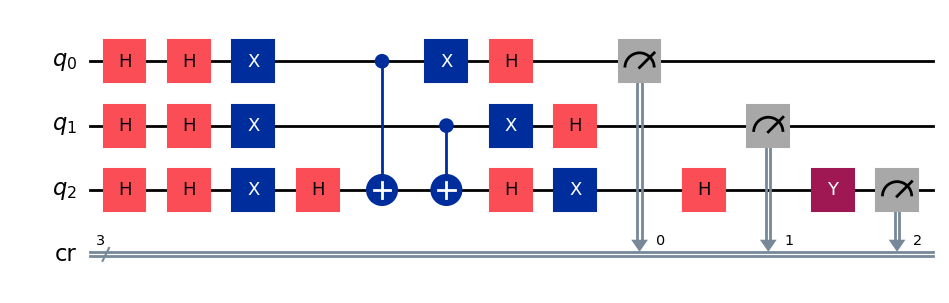

gen = 0 , Best fitness = (11.2103,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.2074,) , Number of invalids = 7

[Generation 1] Best Fitness: 11.2074 (Ideal Simulation)
  Raw Gate count: 23, Raw Depth: 11
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


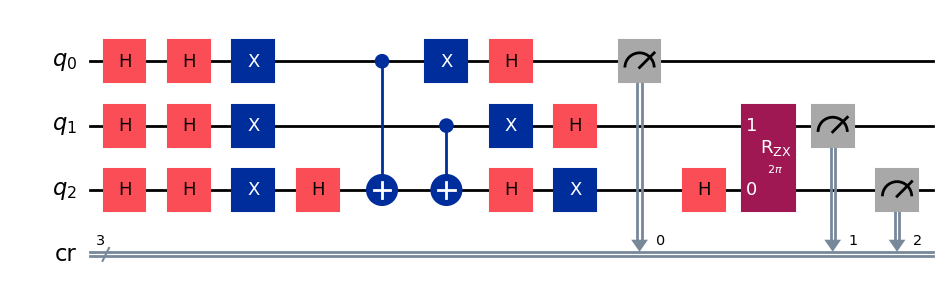

gen = 0 , Best fitness = (11.2074,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.2074,) , Number of invalids = 7

[Generation 2] Best Fitness: 11.2074 (Ideal Simulation)
  Raw Gate count: 23, Raw Depth: 11
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


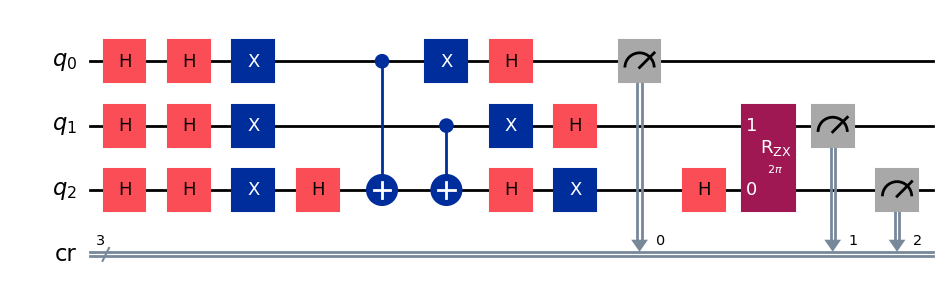

gen = 0 , Best fitness = (11.2074,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.2006,) , Number of invalids = 5

[Generation 3] Best Fitness: 11.2006 (Ideal Simulation)
  Raw Gate count: 24, Raw Depth: 12
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


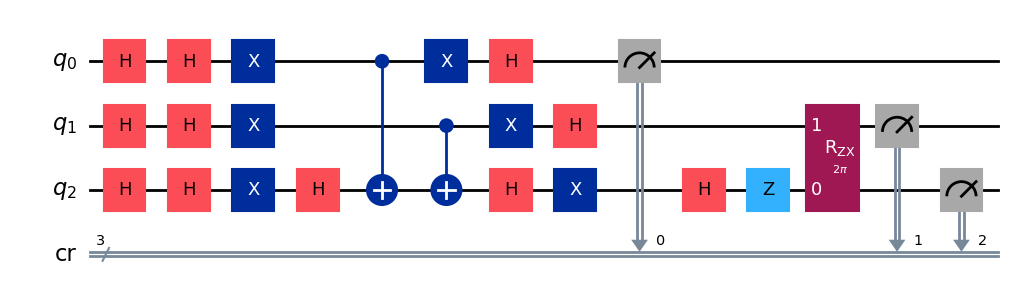

gen = 0 , Best fitness = (11.2006,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.1844,) , Number of invalids = 2

[Generation 4] Best Fitness: 11.1844 (Ideal Simulation)
  Raw Gate count: 23, Raw Depth: 10
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


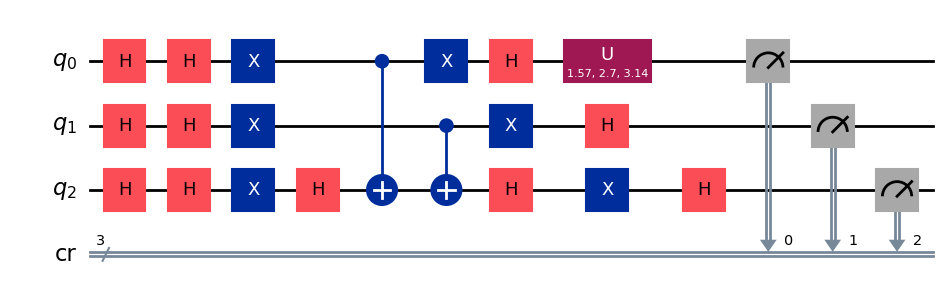

gen = 0 , Best fitness = (11.1844,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.0207,) , Number of invalids = 2

[Generation 5] Best Fitness: 11.0207 (Ideal Simulation)
  Raw Gate count: 23, Raw Depth: 10
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


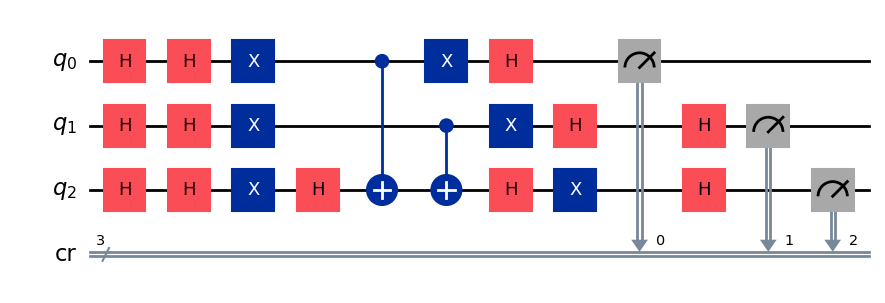

gen = 0 , Best fitness = (11.0207,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.0207,) , Number of invalids = 2

[Generation 6] Best Fitness: 11.0207 (Ideal Simulation)
  Raw Gate count: 23, Raw Depth: 10
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


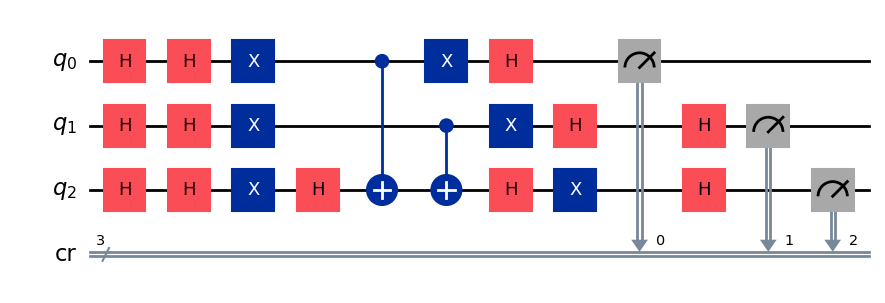

gen = 0 , Best fitness = (11.0207,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.0207,) , Number of invalids = 3

[Generation 7] Best Fitness: 11.0207 (Ideal Simulation)
  Raw Gate count: 23, Raw Depth: 10
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


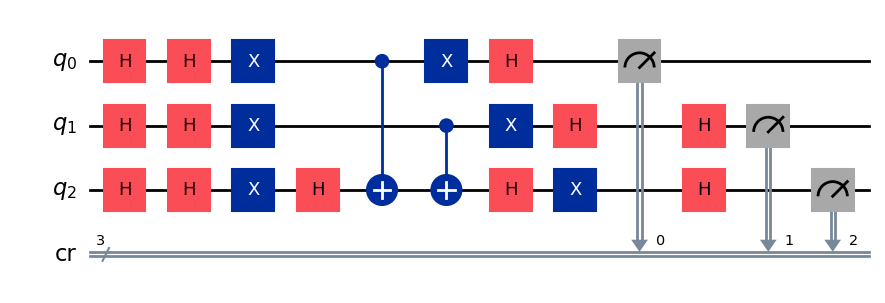

gen = 0 , Best fitness = (11.0207,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.0207,) , Number of invalids = 1

[Generation 8] Best Fitness: 11.0207 (Ideal Simulation)
  Raw Gate count: 23, Raw Depth: 10
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


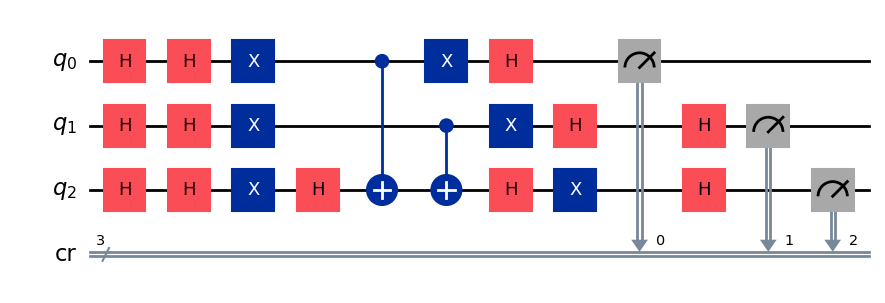

gen = 0 , Best fitness = (11.0207,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (10.8203,) , Number of invalids = 0

[Generation 9] Best Fitness: 10.8203 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


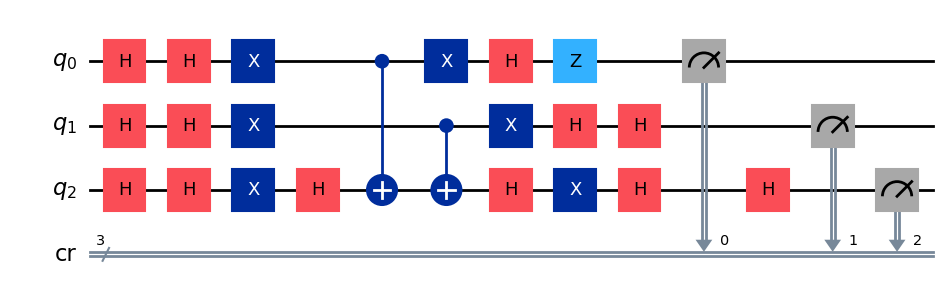

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_9.pkl
gen = 0 , Best fitness = (10.8203,)
gen = 1 , Best fitness = (10.8203,) , Number of invalids = 0

[Generation 10] Best Fitness: 10.8203 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


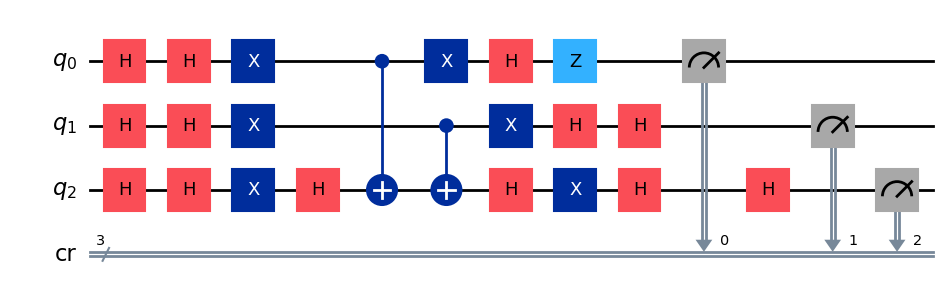

gen = 0 , Best fitness = (10.8203,)
gen = 1 , Best fitness = (10.8203,) , Number of invalids = 0

[Generation 11] Best Fitness: 10.8203 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


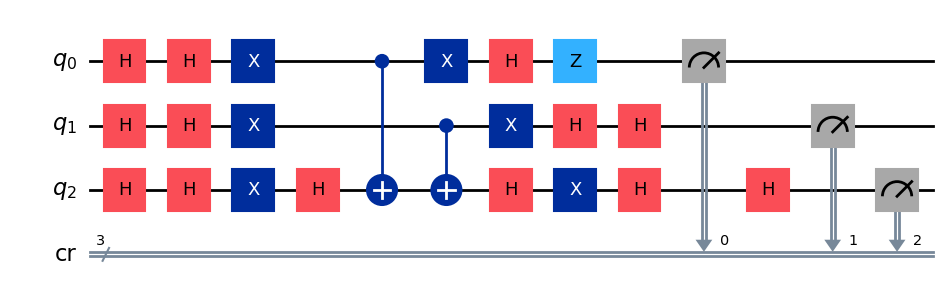

gen = 0 , Best fitness = (10.8203,)
gen = 1 , Best fitness = (10.8203,) , Number of invalids = 0

[Generation 12] Best Fitness: 10.8203 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


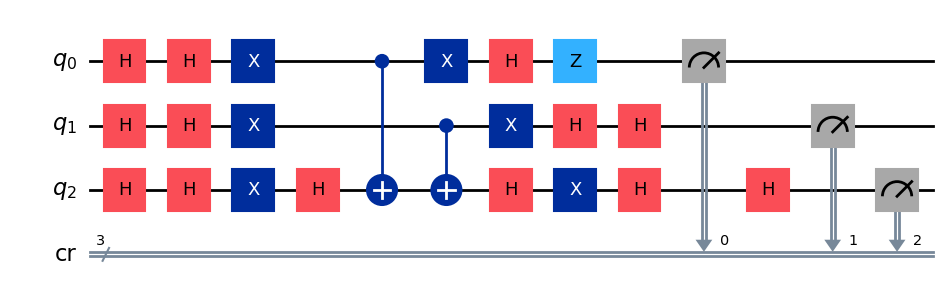

gen = 0 , Best fitness = (10.8203,)
gen = 1 , Best fitness = (10.8095,) , Number of invalids = 0

[Generation 13] Best Fitness: 10.8095 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


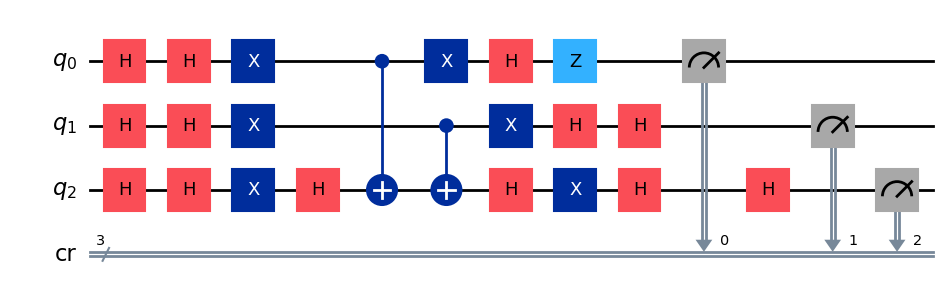

gen = 0 , Best fitness = (10.8095,)
gen = 1 , Best fitness = (10.8095,) , Number of invalids = 0

[Generation 14] Best Fitness: 10.8095 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


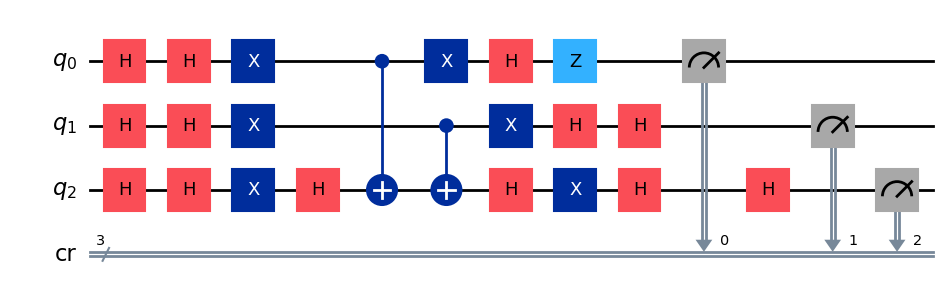

gen = 0 , Best fitness = (10.8095,)
gen = 1 , Best fitness = (10.8051,) , Number of invalids = 0

[Generation 15] Best Fitness: 10.8051 (Ideal Simulation)
  Raw Gate count: 24, Raw Depth: 11
[Raw Circuit]


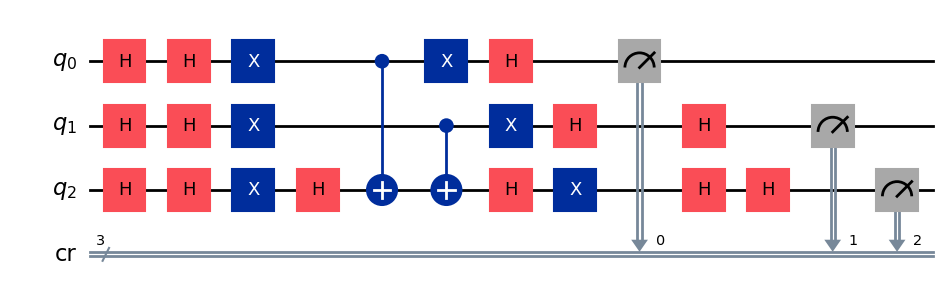

gen = 0 , Best fitness = (10.8051,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 16] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


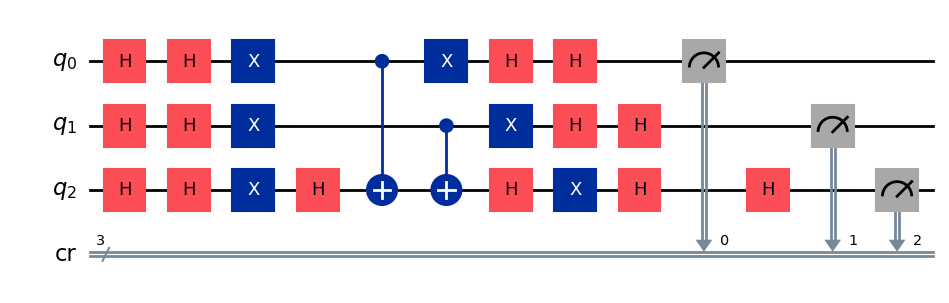

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 17] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


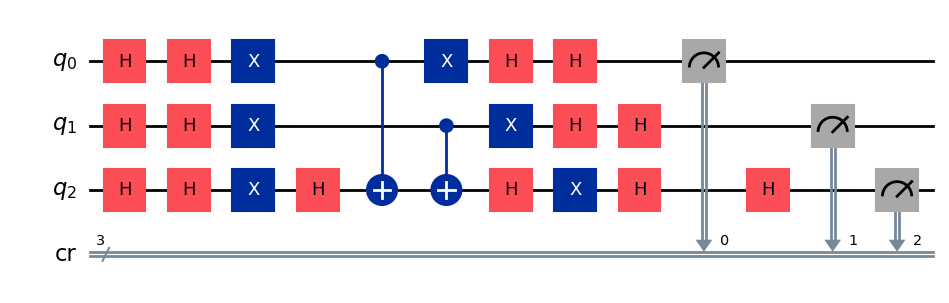

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 18] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


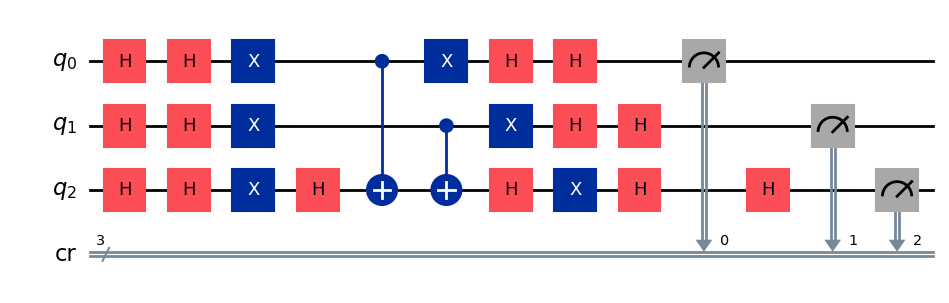

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 19] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


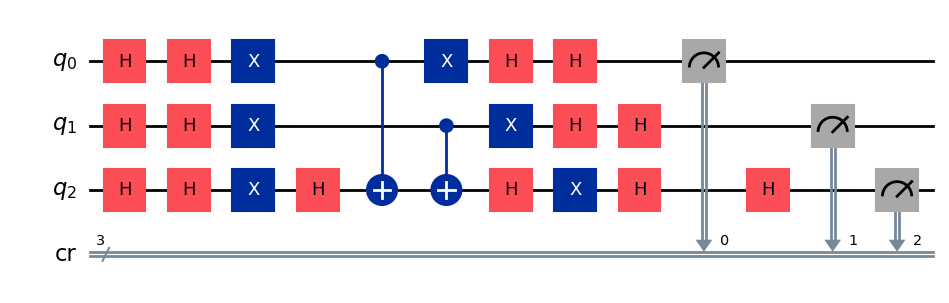

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_19.pkl
gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 20] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 11
[Raw Circuit]


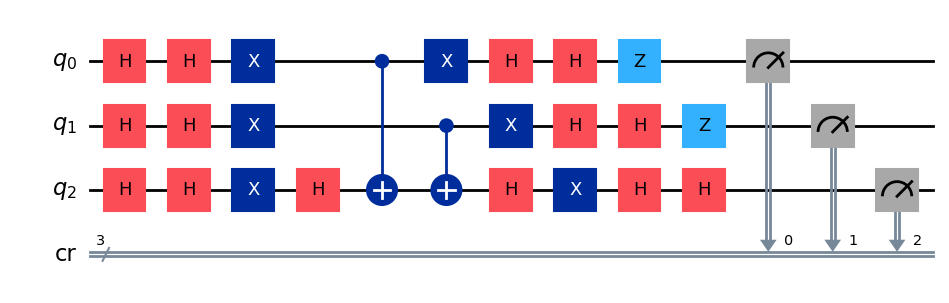

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 21] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 12
[Raw Circuit]


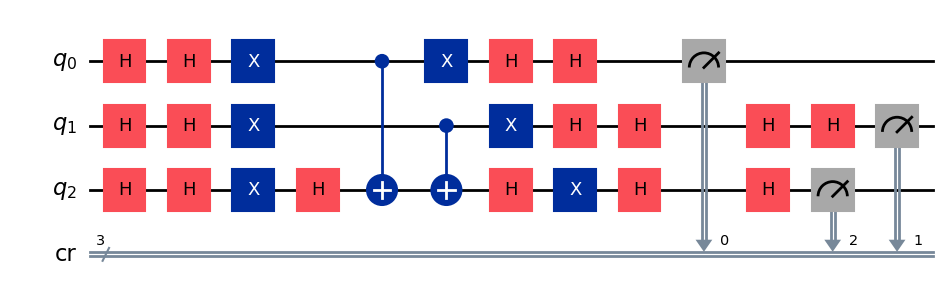

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 22] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 12
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


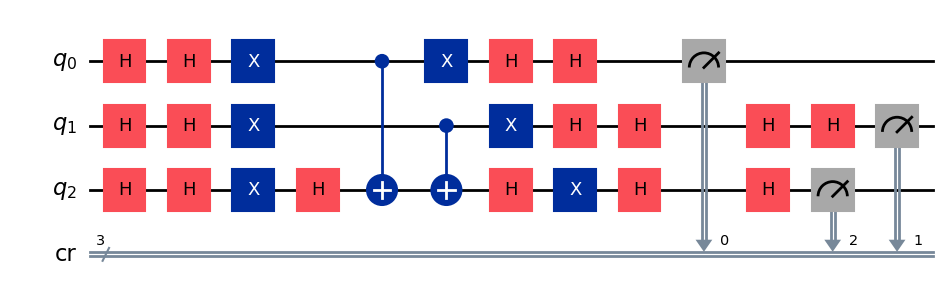

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 23] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


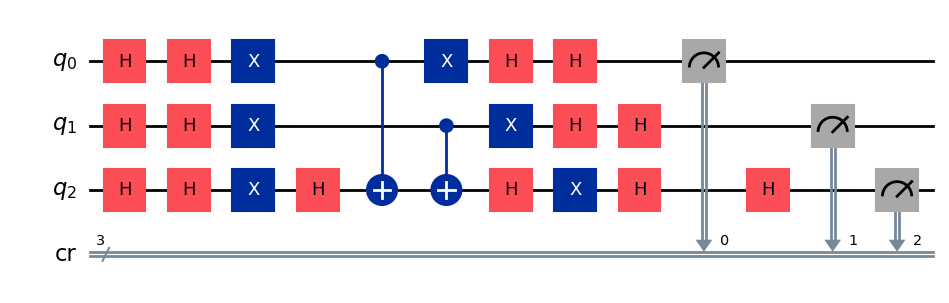

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 24] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 12
[Raw Circuit]


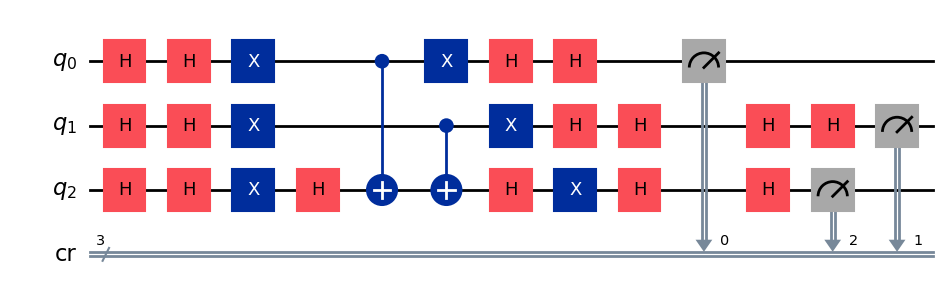

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 25] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


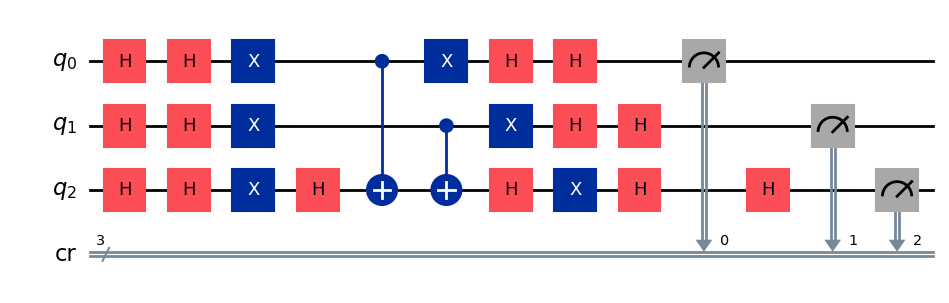

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 26] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


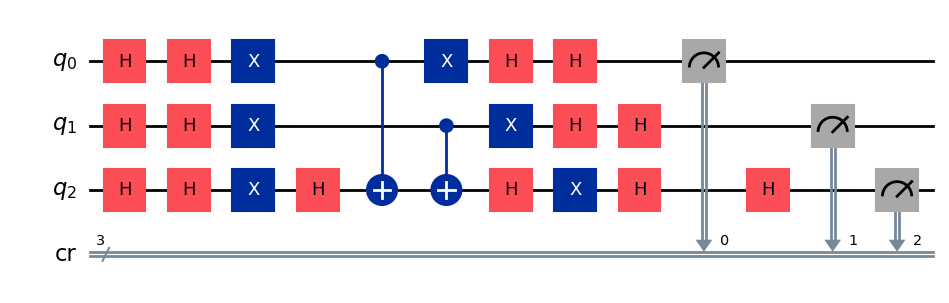

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 27] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


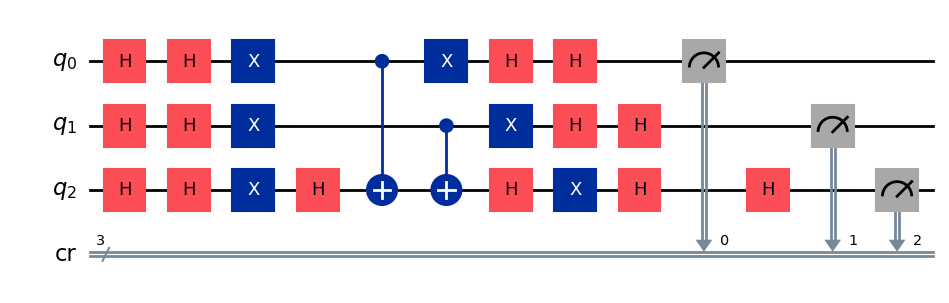

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 28] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


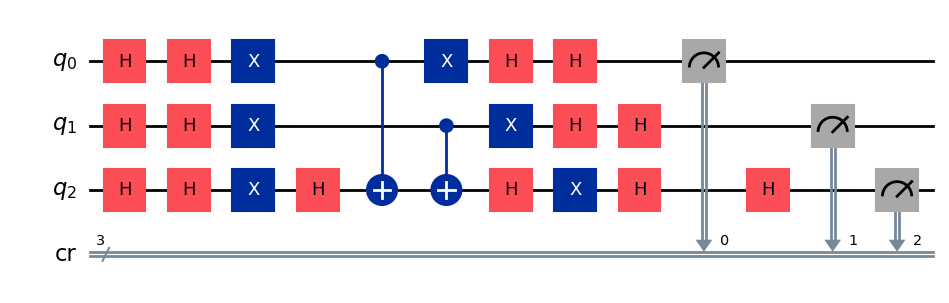

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 29] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


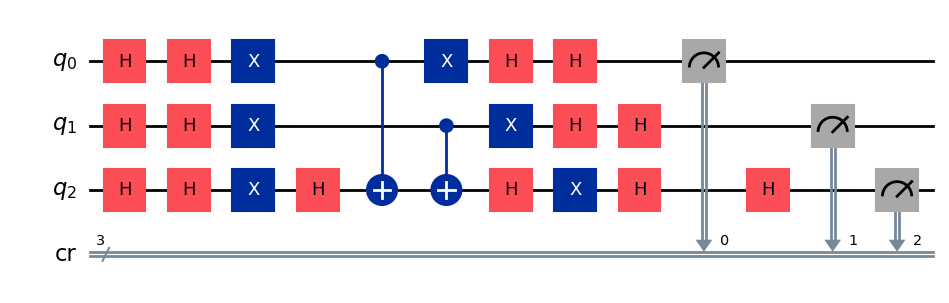

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_29.pkl
gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 30] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


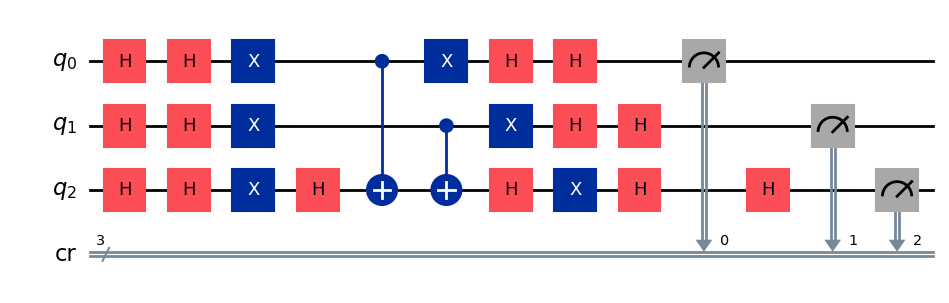

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 31] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


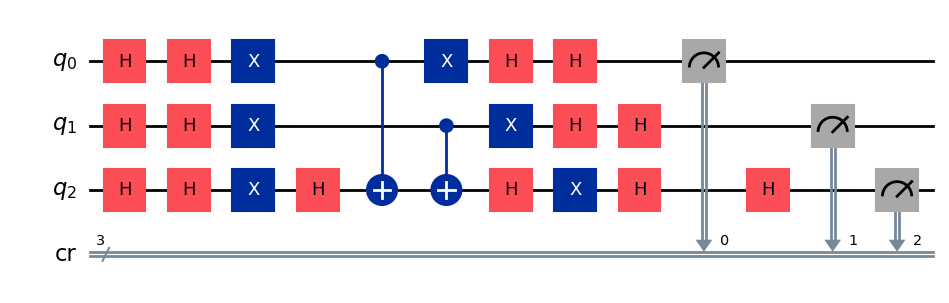

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 32] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


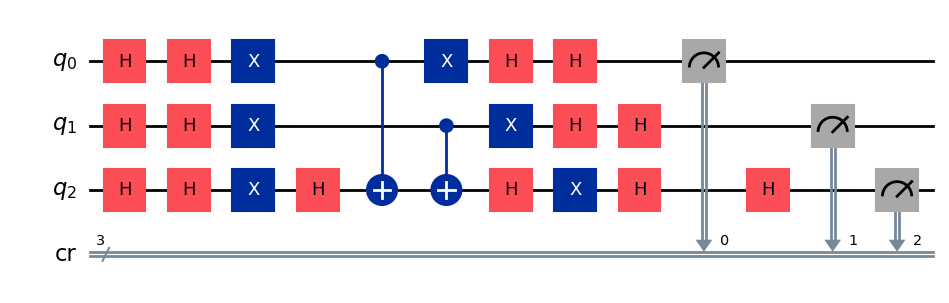

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 33] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


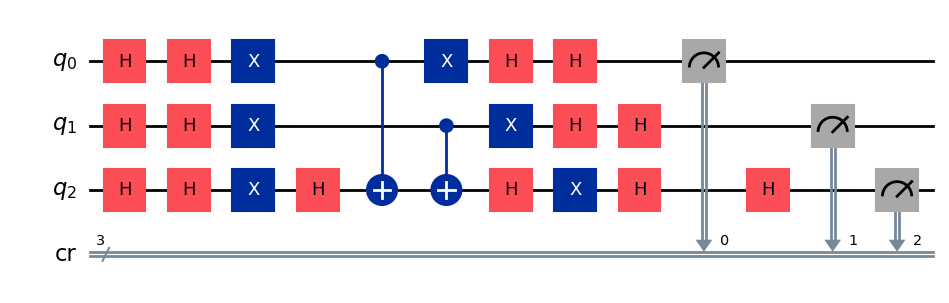

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 34] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


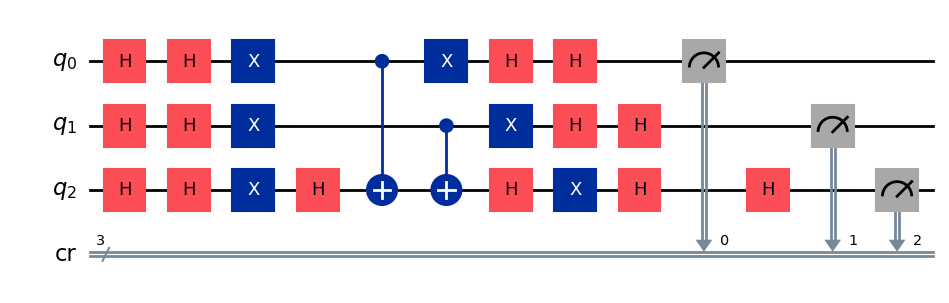

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 35] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


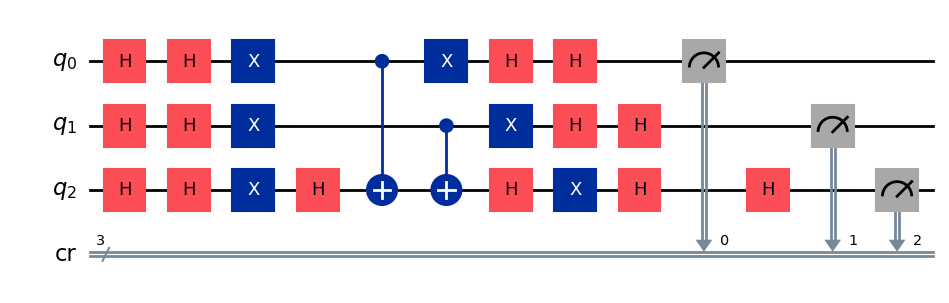

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 36] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


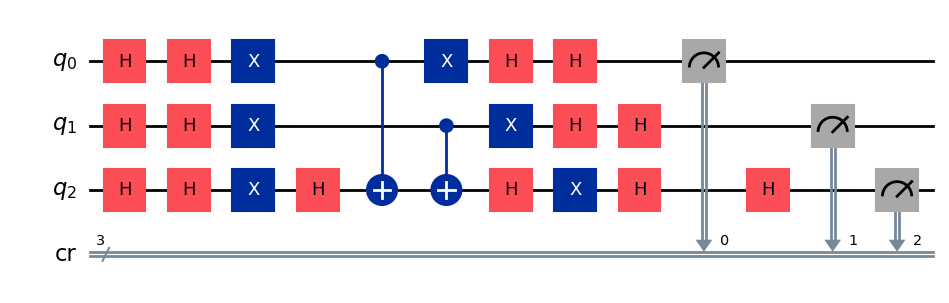

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 37] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


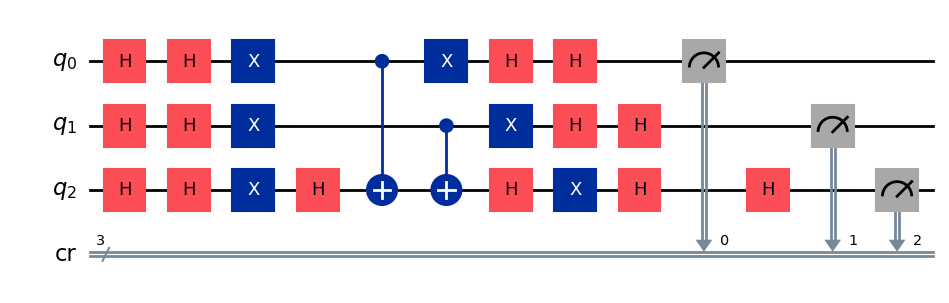

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 38] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


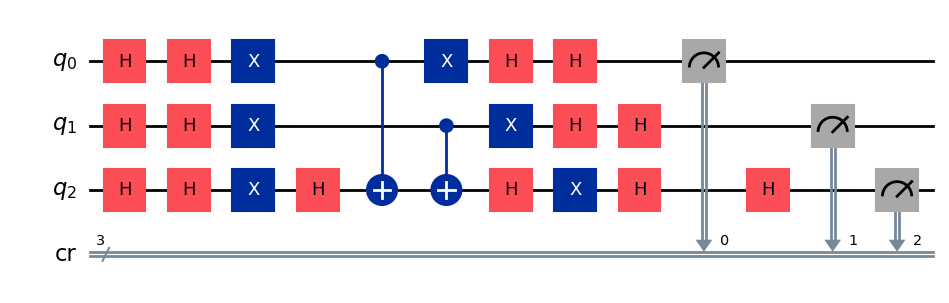

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 39] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


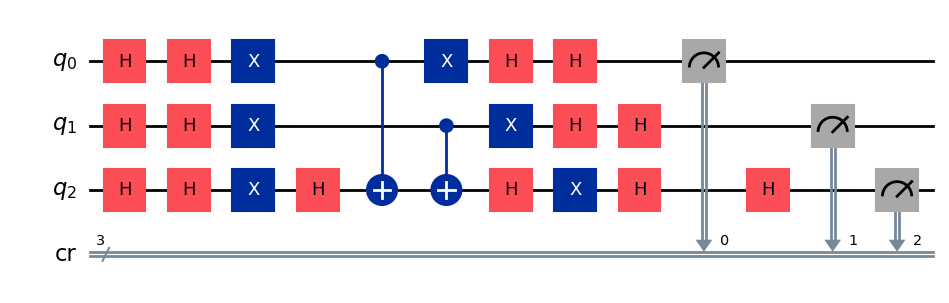

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_39.pkl
gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 40] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


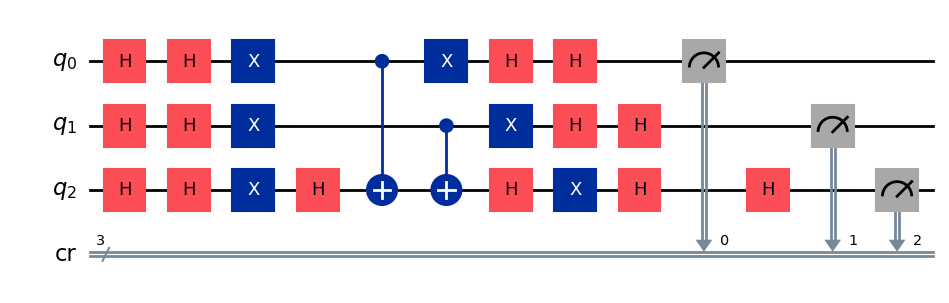

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 41] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


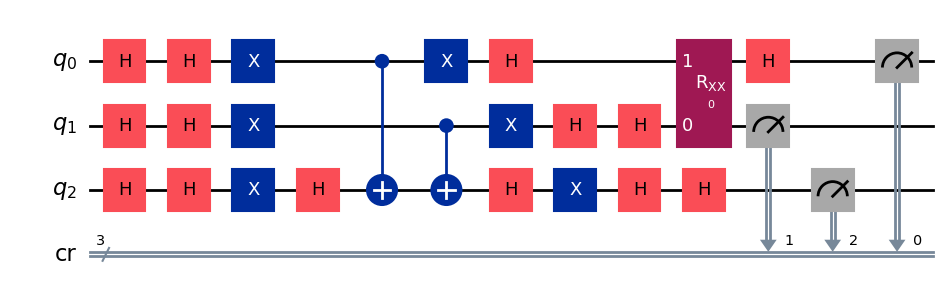

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 42] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 13
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


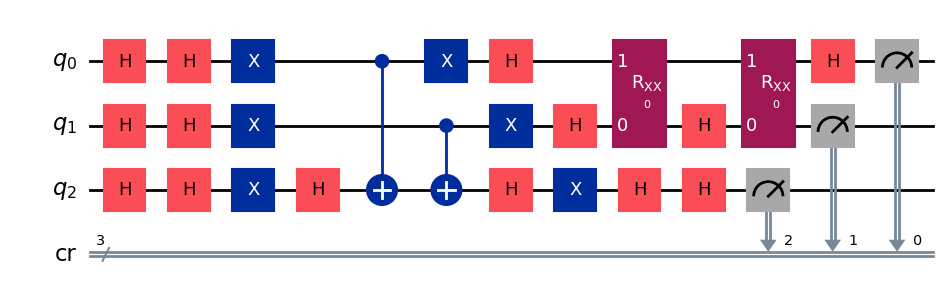

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 43] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


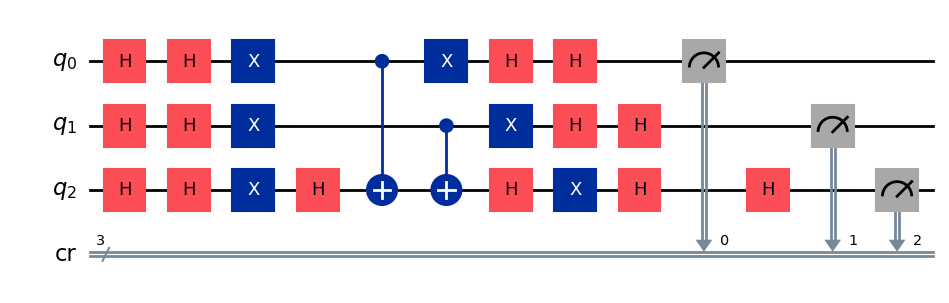

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 44] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


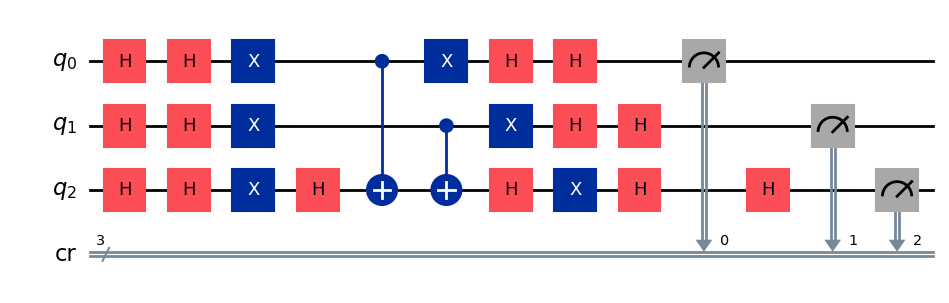

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 45] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 13
[Raw Circuit]


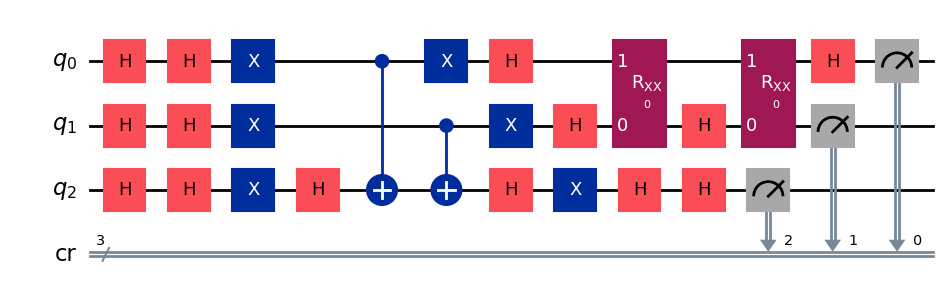

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 46] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


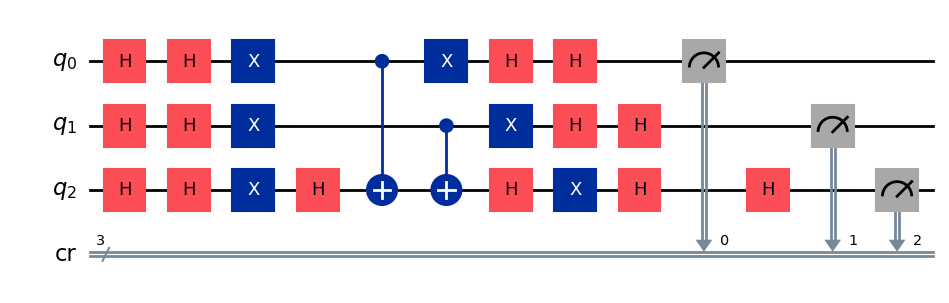

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 47] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


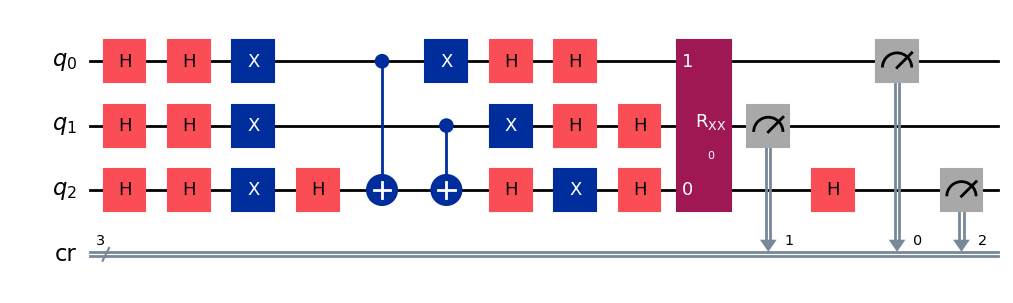

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 48] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 13
[Raw Circuit]


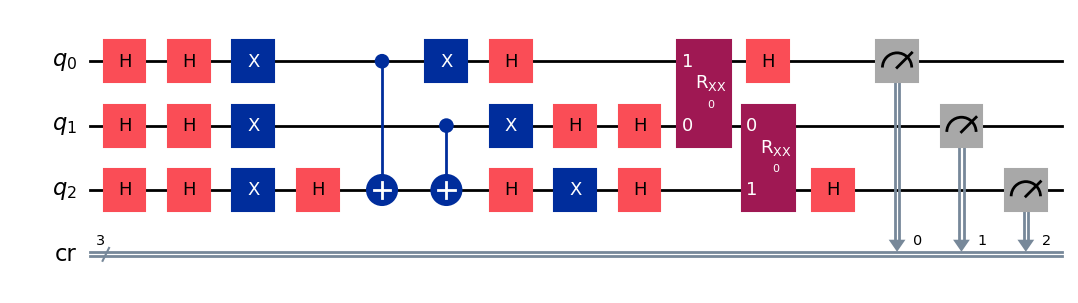

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 49] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


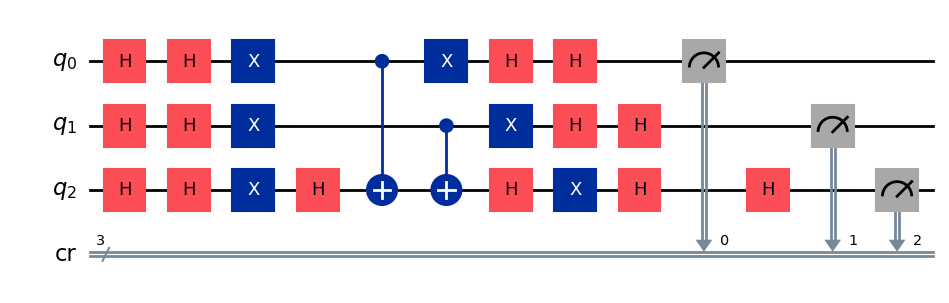

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_49.pkl
gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 50] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


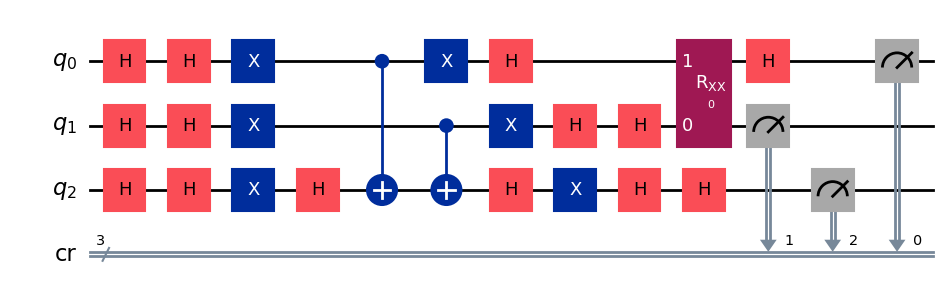

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 51] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


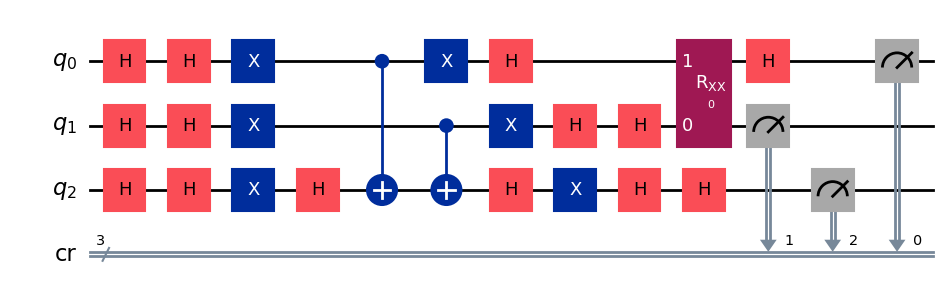

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 52] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


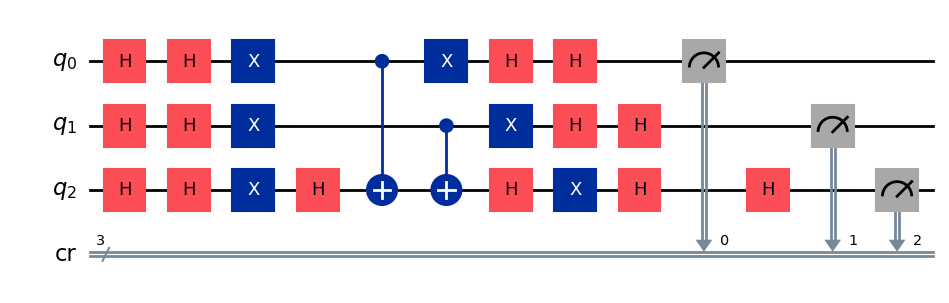

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 53] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


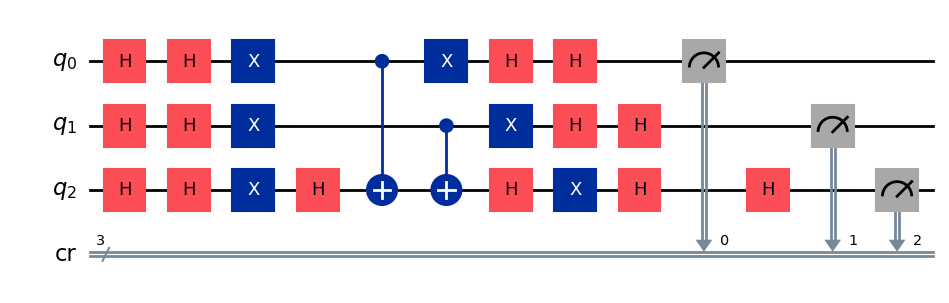

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 54] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


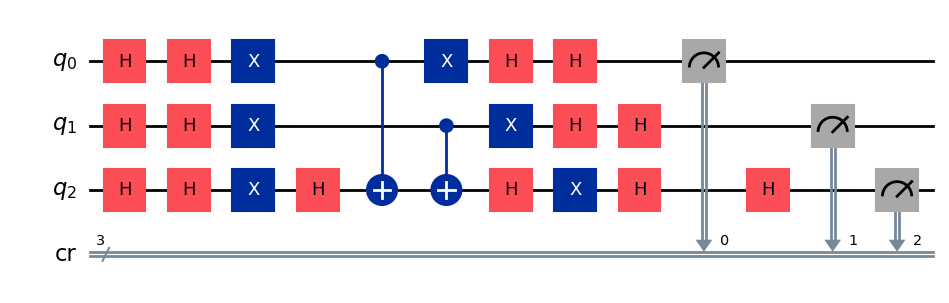

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 55] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


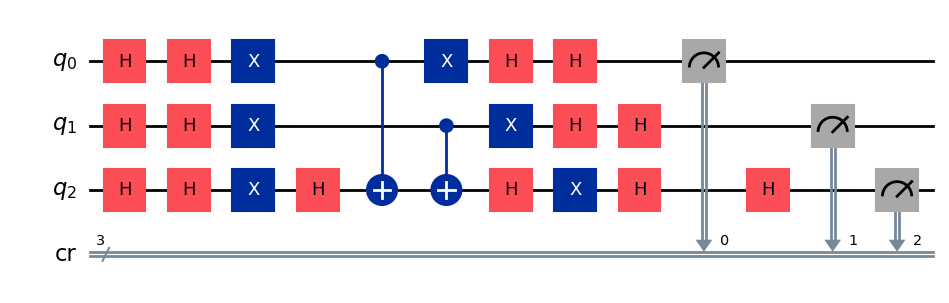

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 56] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


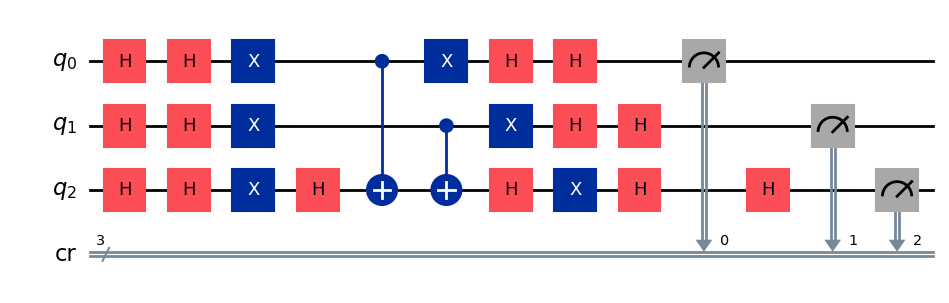

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 57] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


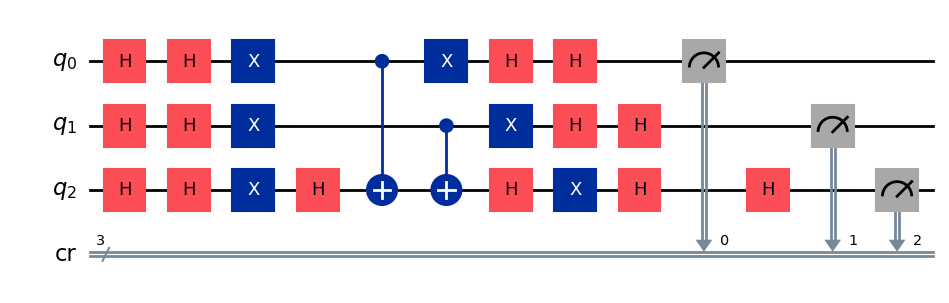

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 58] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


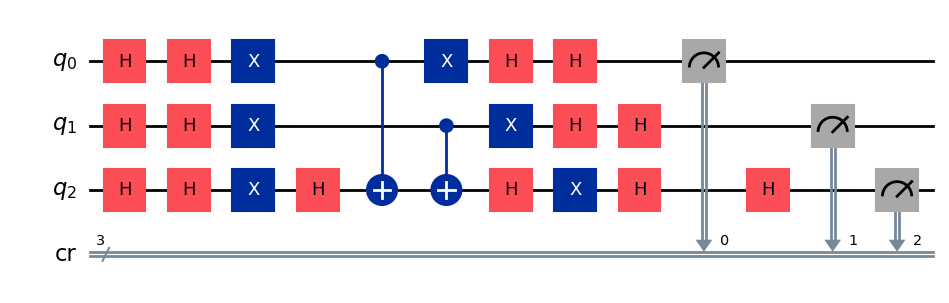

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 59] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


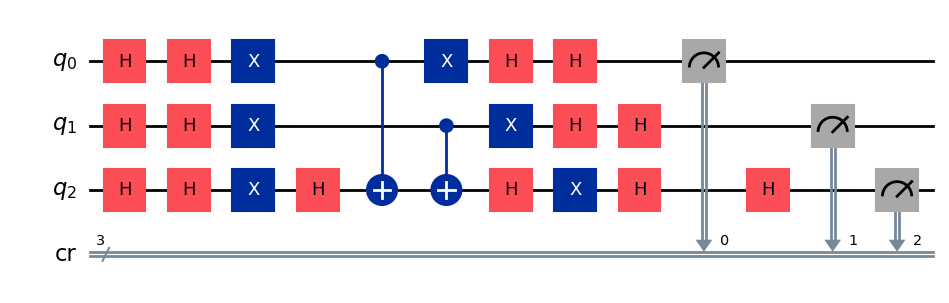

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_59.pkl
gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 60] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


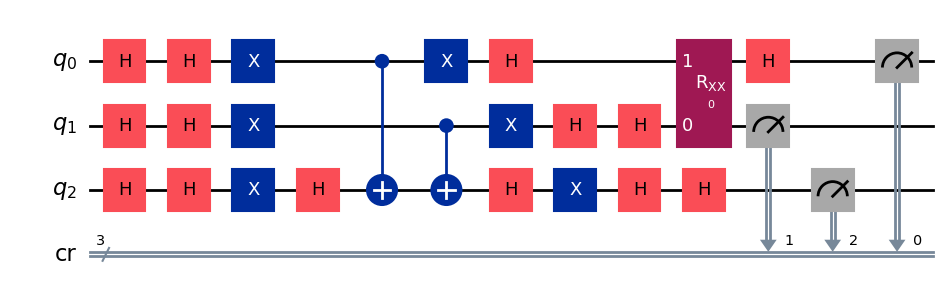

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 61] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


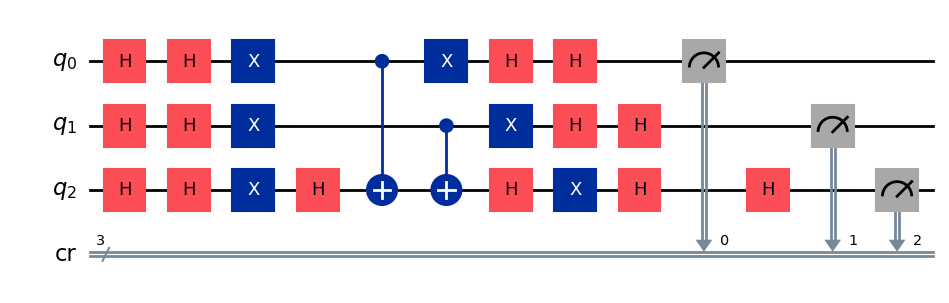

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 62] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


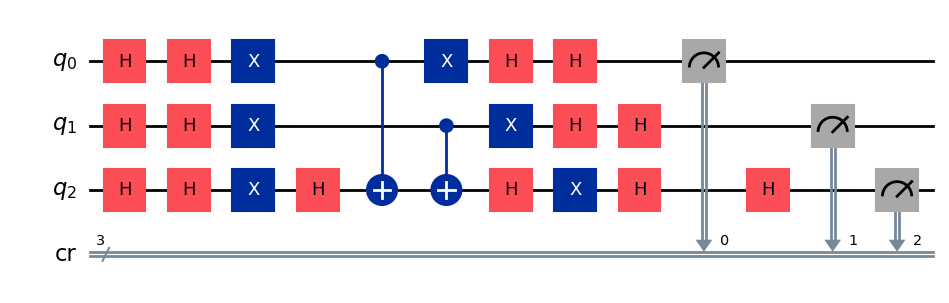

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 63] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


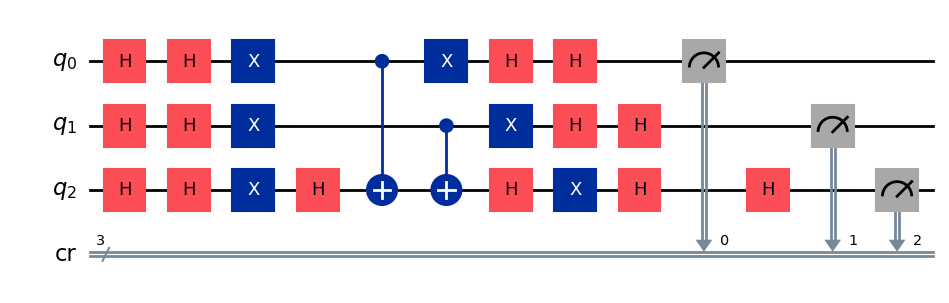

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 64] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


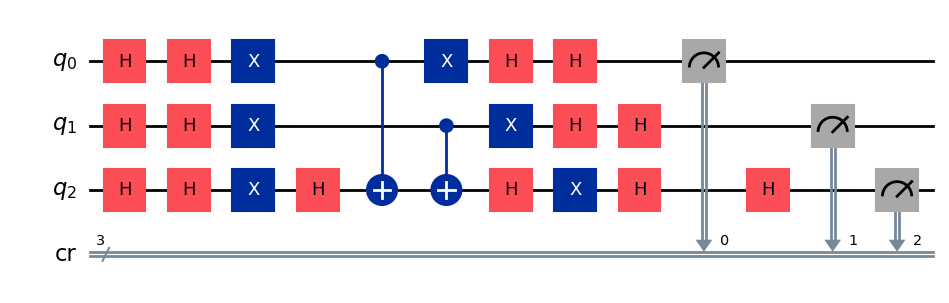

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 65] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


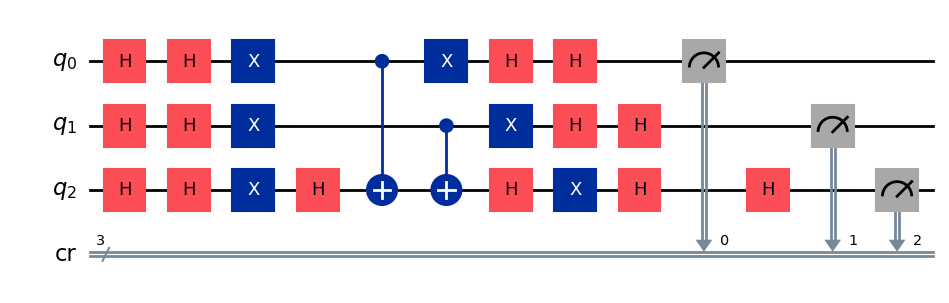

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 66] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


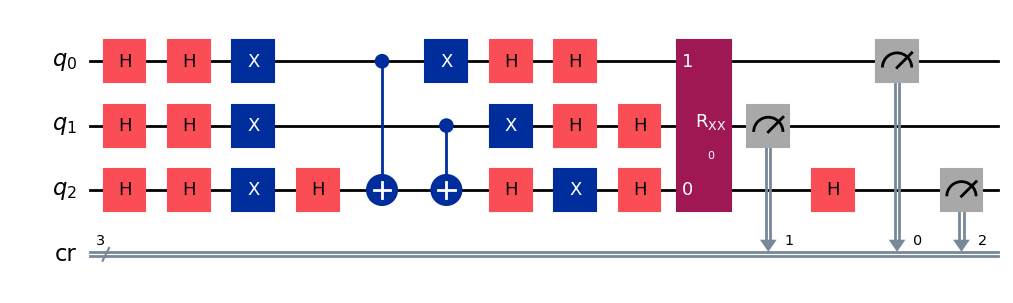

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 67] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 11
[Raw Circuit]


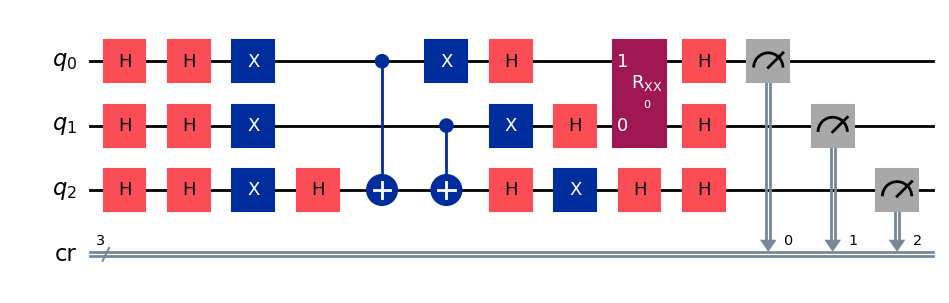

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 68] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 29, Raw Depth: 15
[Raw Circuit]


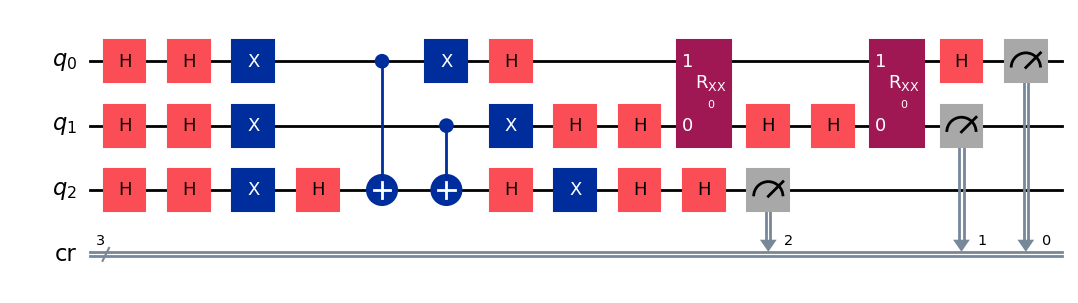

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 69] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


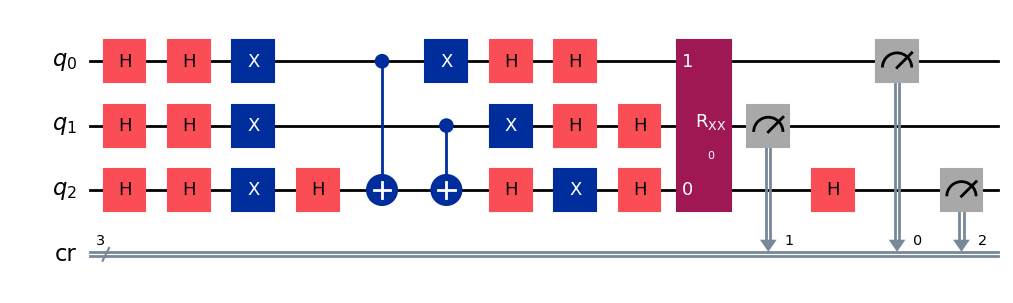

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_69.pkl
gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 70] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


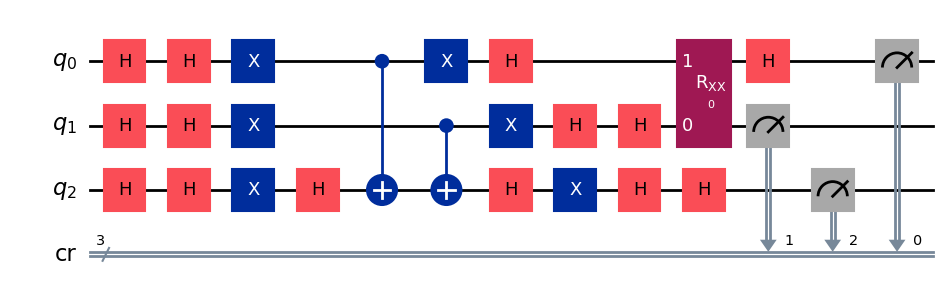

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 71] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


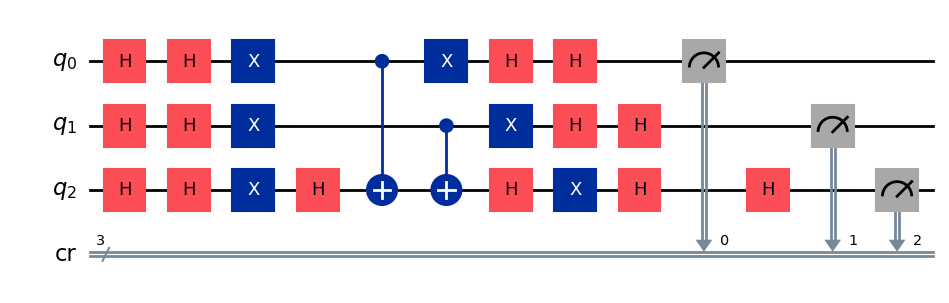

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 72] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 28, Raw Depth: 14
[Raw Circuit]


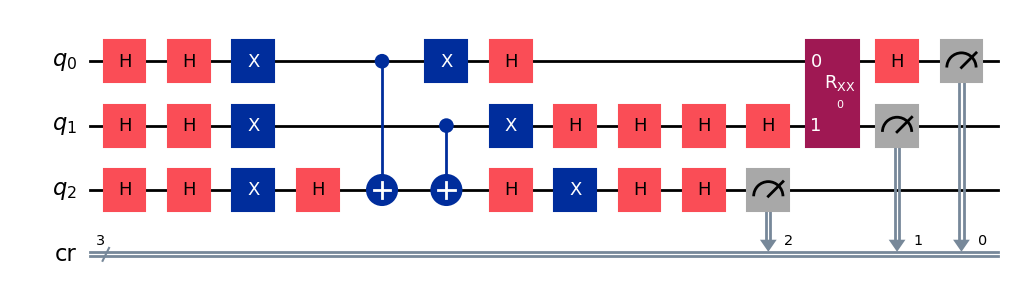

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 73] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


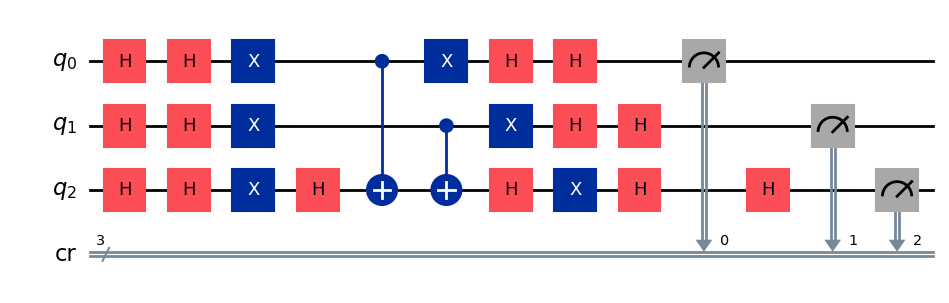

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 74] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


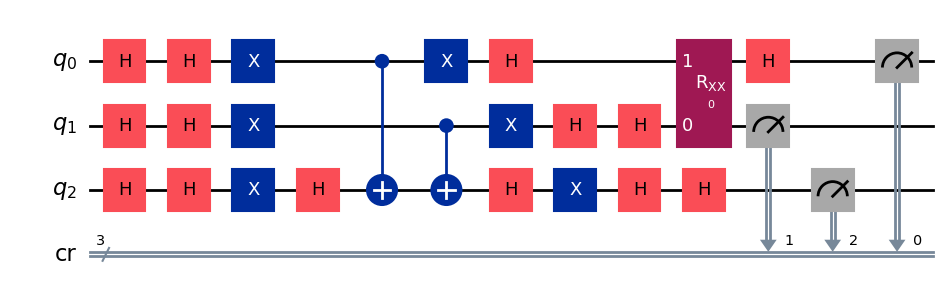

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 75] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


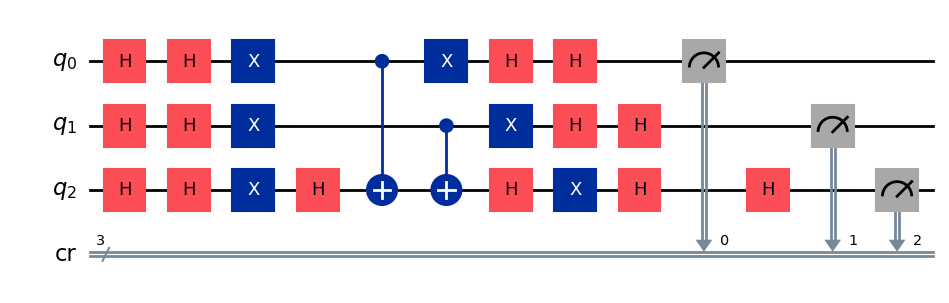

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 3

[Generation 76] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


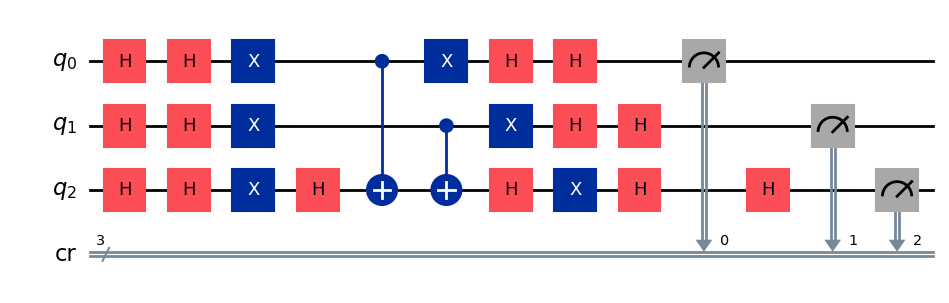

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 77] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 12
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


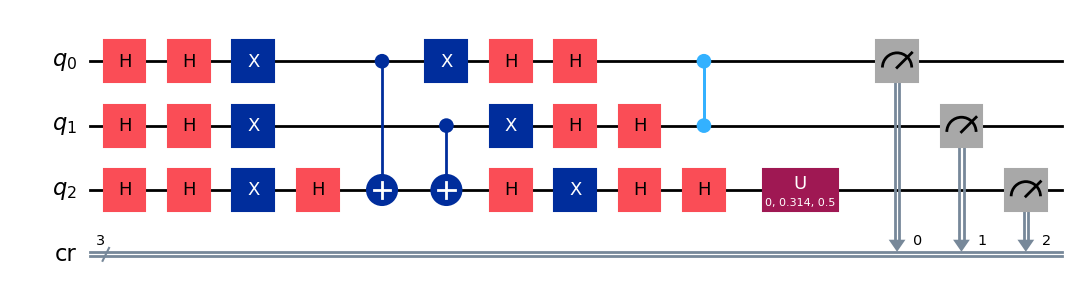

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 78] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 28, Raw Depth: 12
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


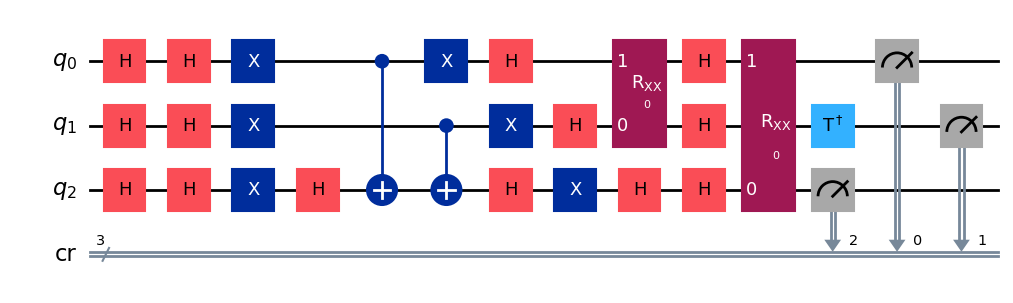

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 79] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 12
[Raw Circuit]


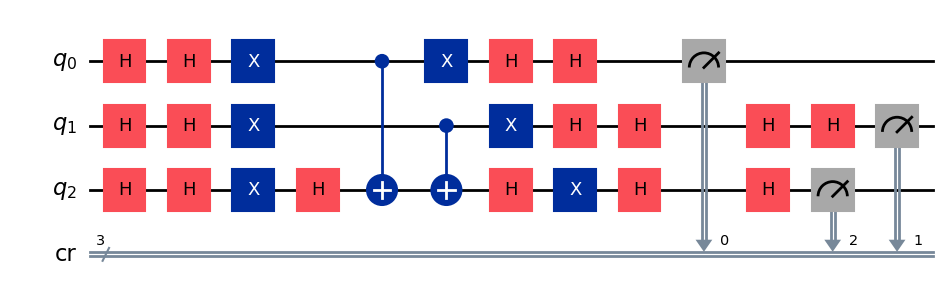

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_79.pkl
gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 80] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


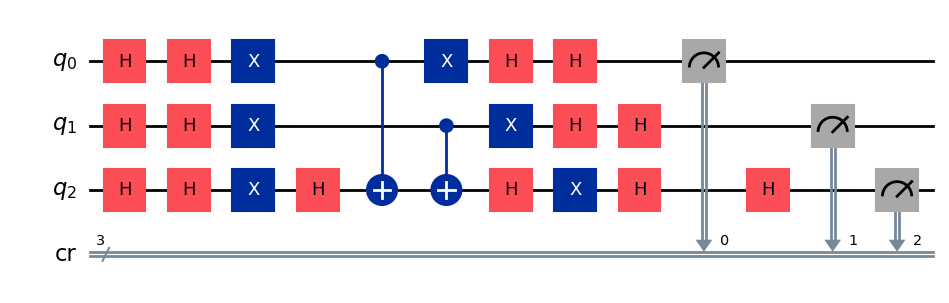

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 81] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 11
[Raw Circuit]


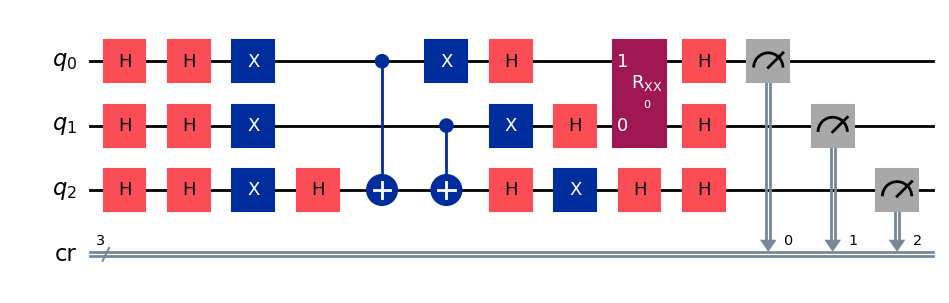

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 82] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


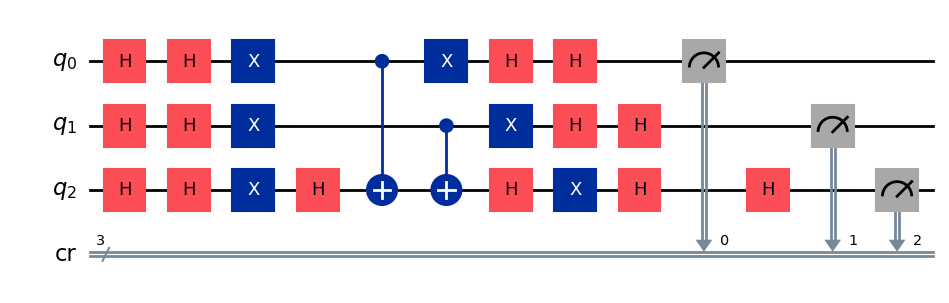

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 83] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


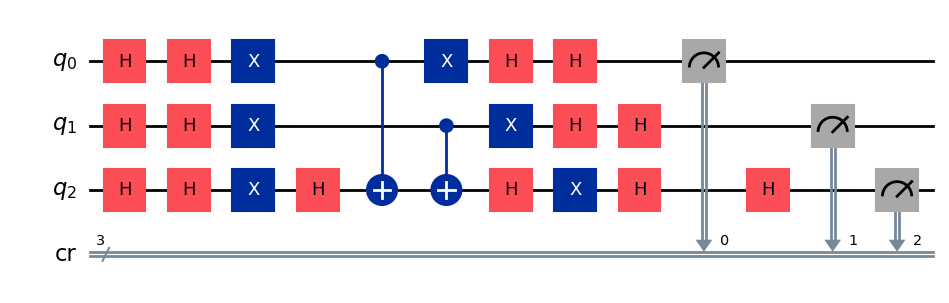

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 84] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


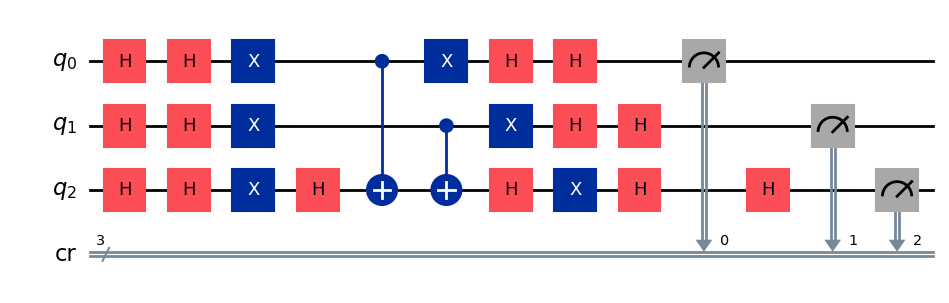

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 85] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


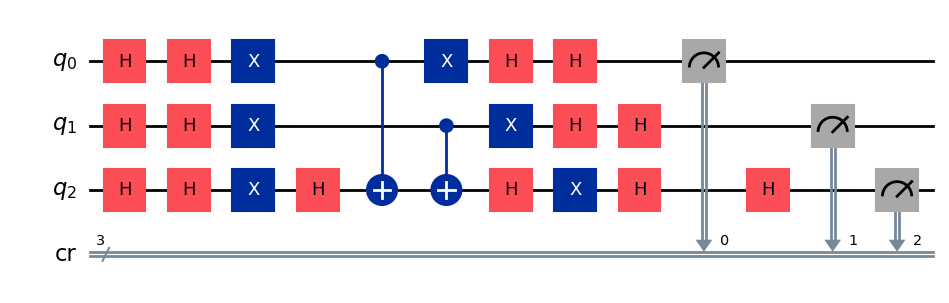

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 86] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


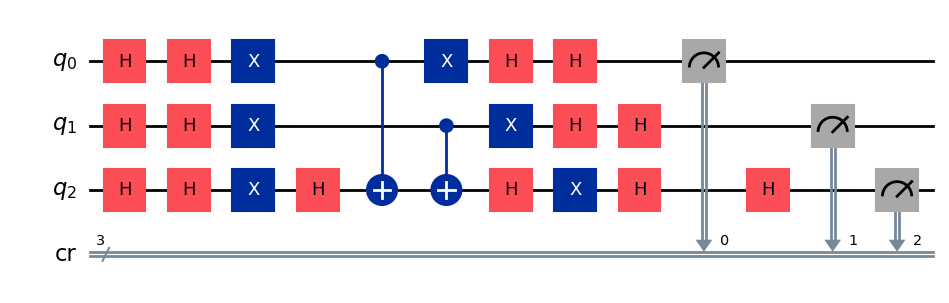

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 87] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


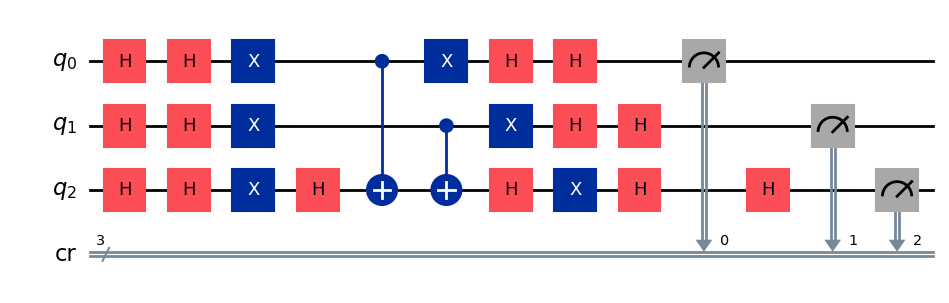

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 88] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 12
[Raw Circuit]


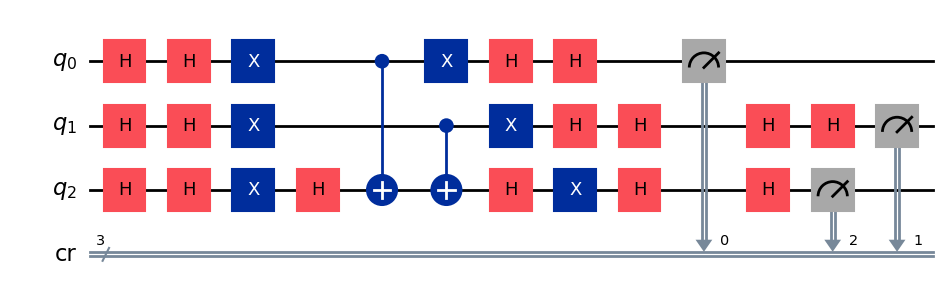

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 89] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 11
[Raw Circuit]


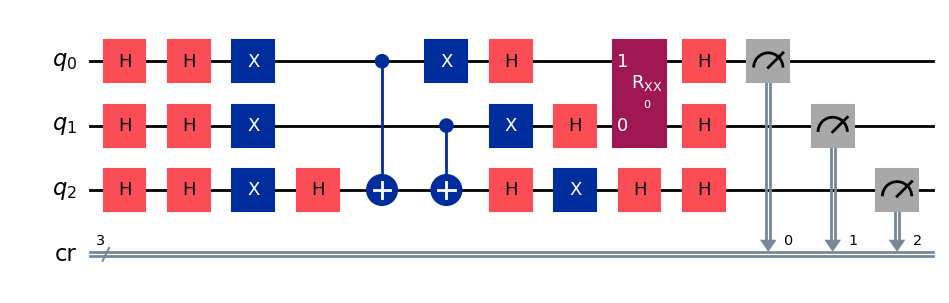

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_89.pkl
gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 90] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


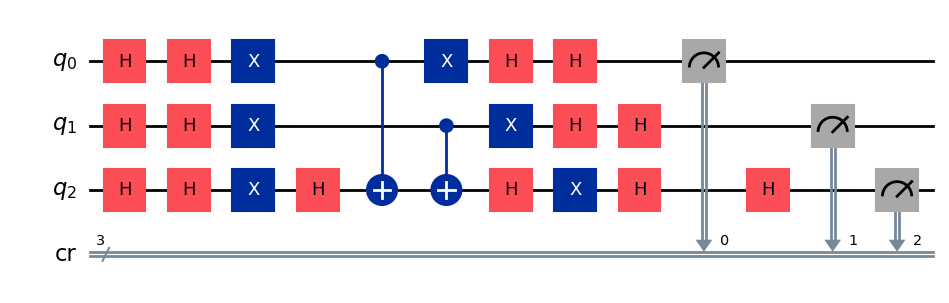

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 1

[Generation 91] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


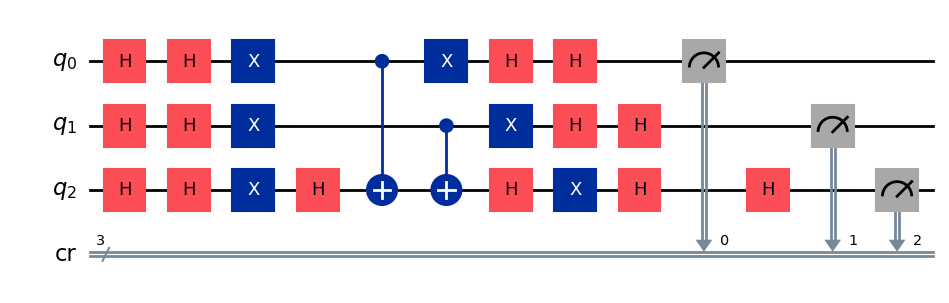

gen = 0 , Best fitness = (0.36,)


/Users/caephas/Downloads/LERO/Grover-GE/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 92] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 12
[Raw Circuit]


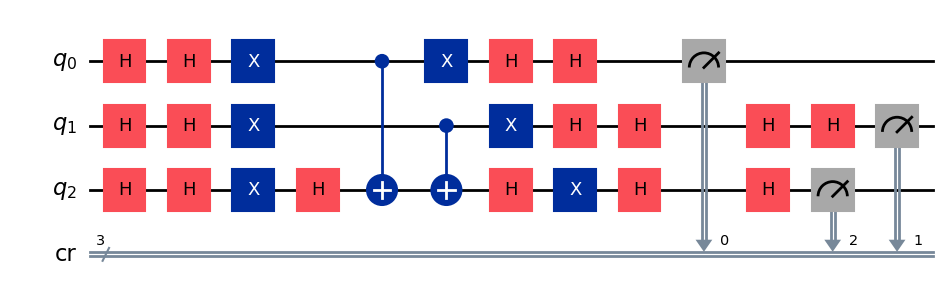

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 93] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 25, Raw Depth: 11
[Raw Circuit]


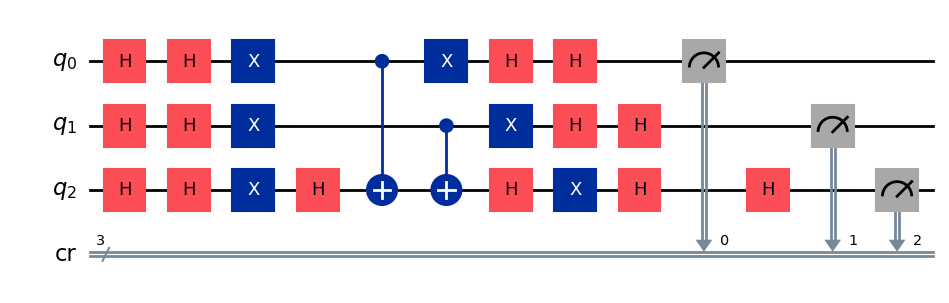

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 94] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 11
[Raw Circuit]


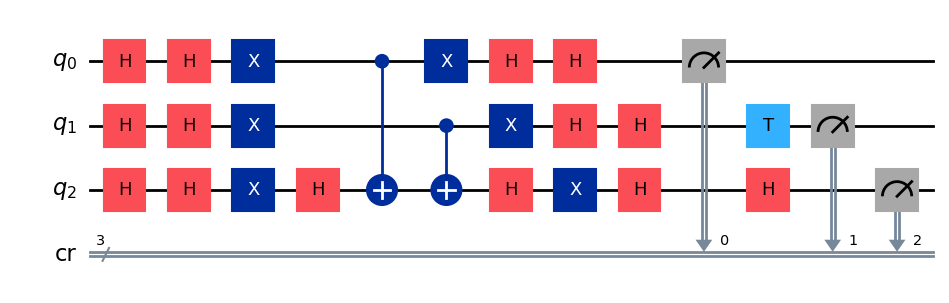

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 95] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 11
[Raw Circuit]


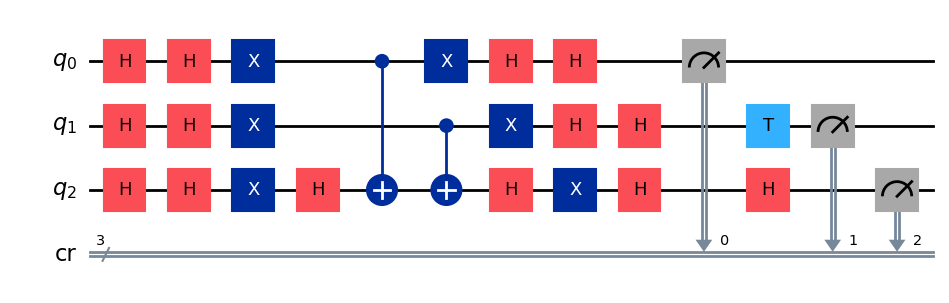

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 96] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


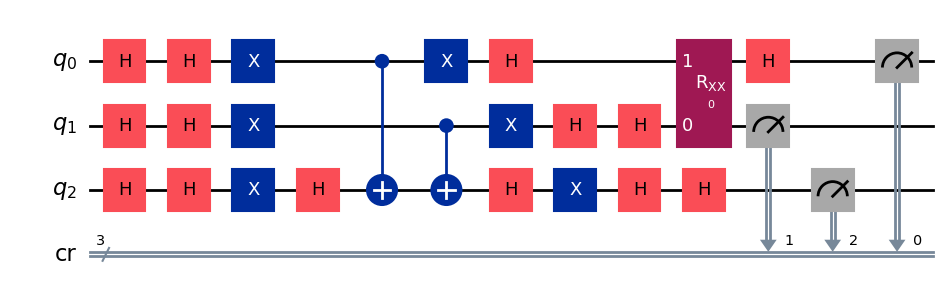

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 97] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 12
[Raw Circuit]


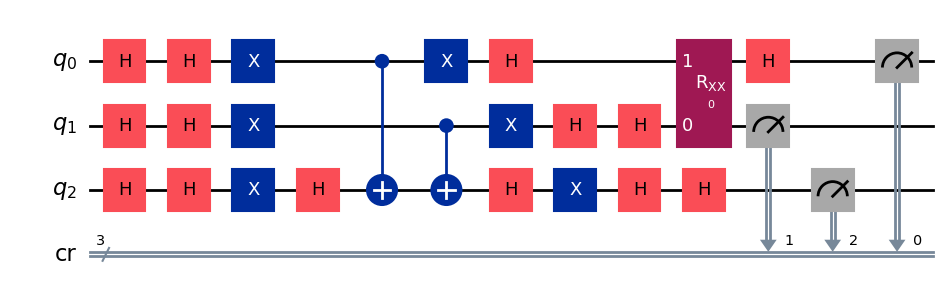

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 98] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 27, Raw Depth: 13
[Raw Circuit]


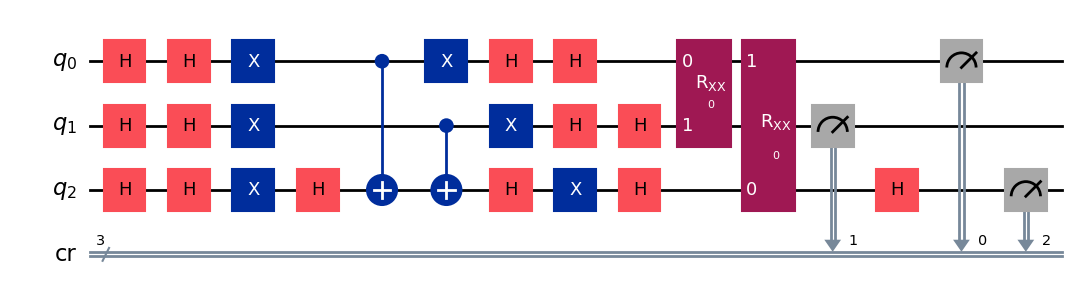

gen = 0 , Best fitness = (0.36,)
gen = 1 , Best fitness = (0.36,) , Number of invalids = 0

[Generation 99] Best Fitness: 0.3600 (Ideal Simulation)
  Raw Gate count: 26, Raw Depth: 11
[Raw Circuit]


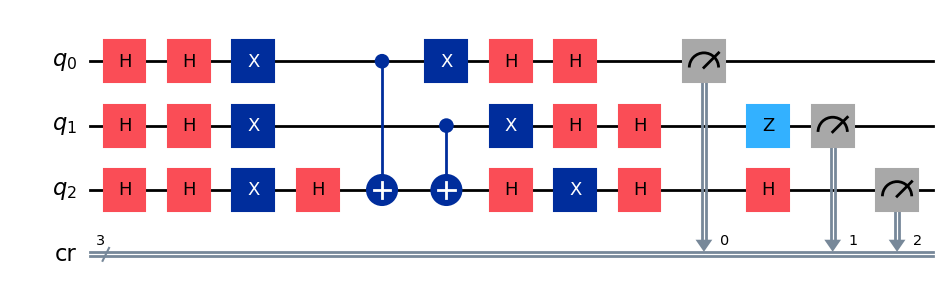

✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_99.pkl
✓ Checkpoint saved: checkpoints_ideal/checkpoint_gen_99.pkl

✓ Evolution complete! Final checkpoint saved.


In [19]:
# Check for existing checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, "checkpoint_latest.pkl")
start_gen = 0

if os.path.exists(checkpoint_path):
    print(f"\n{'='*60}")
    print("Found existing checkpoint!")
    print(f"{'='*60}")
    
    checkpoint_data = load_checkpoint(checkpoint_path)
    if checkpoint_data:
        population = checkpoint_data['population']
        start_gen = checkpoint_data['generation'] + 1
        hof = checkpoint_data['hof']
        best_fitness_list = checkpoint_data['best_fitness_list']
        avg_gate_count_list = checkpoint_data['avg_gate_count_list']
        generations_list = checkpoint_data['generations_list']
        print(f"Resuming from generation {start_gen}")
    else:
        print("Checkpoint corrupted, starting fresh")
        start_gen = 0
else:
    print(f"\n{'='*60}")
    print("Starting fresh evolution (no checkpoint found)")
    print(f"Noise Model: {'ENABLED' if USE_NOISE_MODEL else 'DISABLED'}")
    print(f"{'='*60}")

# Only create new population if not loaded from checkpoint
if start_gen == 0:
    evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR, seed=RANDOM_SEED, use_noise=USE_NOISE_MODEL)
    
    # Set seeds again before creating initial population
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    population = toolbox.populationCreator(
        pop_size=POPULATION_SIZE,
        bnf_grammar=BNF_GRAMMAR,
        min_init_depth=MIN_INIT_DEPTH,
        max_init_depth=MAX_INIT_DEPTH,
        codon_size=CODON_SIZE,
        codon_consumption=CODON_CONSUMPTION,
        genome_representation=GENOME_REPRESENTATION
    )
    hof = tools.HallOfFame(HALLOFFAME_SIZE)
    
    generations_list = []
    best_fitness_list = []
    avg_gate_count_list = []

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
try:
    for gen in range(start_gen, MAX_GENERATIONS):
        # Re-seed at the beginning of each generation for consistency
        random.seed(RANDOM_SEED + gen)
        
        population, logbook = algorithms.ge_eaSimpleWithElitism(
            population,
            toolbox,
            cxpb=P_CROSSOVER,
            mutpb=P_MUTATION,
            ngen=N_GEN,
            elite_size=ELITE_SIZE,
            bnf_grammar=BNF_GRAMMAR,
            codon_size=CODON_SIZE,
            max_tree_depth=MAX_TREE_DEPTH,
            codon_consumption=CODON_CONSUMPTION,
            report_items=REPORT_ITEMS,
            genome_representation=GENOME_REPRESENTATION,
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        best_ind = tools.selBest(population, 1)[0]
        best_ind.generation = gen

        best_phenotype = evaluator.decode_individual(best_ind)
        if best_phenotype is not None:
            genome_hash = hash(tuple(best_ind.genome))
            individual_seed = (RANDOM_SEED + genome_hash) % (2**32)
            
            fitness_val, logs = fitness_function_specialized_state_000(
                best_phenotype, 
                shots=NUM_SHOTS, 
                threshold=SUCCESS_THRESHOLD, 
                gate_penalty_weight=GATE_PENALTY_WEIGHT,
                target_state=TARGET_STATE, 
                log_states=True,
                individual_seed=individual_seed,
                use_noise=USE_NOISE_MODEL,
            )
            best_fitness_list.append(fitness_val)
            if logs:
                avg_gate = np.mean([log["gate_count"] for log in logs])
                avg_depth = np.mean([log["depth"] for log in logs])
            else:
                avg_gate = 0
                avg_depth = 0
            avg_gate_count_list.append(avg_gate)
            generations_list.append(gen)

        qc = evaluator.execute_circuit(best_phenotype)
        if qc:
            sim_type = "Noise-Aware" if USE_NOISE_MODEL else "Ideal"
            print(f"\n[Generation {gen}] Best Fitness: {best_ind.fitness.values[0]:.4f} ({sim_type} Simulation)")
            
            if USE_NOISE_MODEL:
                print(f"  Transpiled Gate count: {avg_gate:.1f}, Transpiled Depth: {avg_depth:.1f}")
            else:
                print(f"  Raw Gate count: {qc.size()}, Raw Depth: {qc.depth()}")
            
            # Show raw circuit
            print("[Raw Circuit]")
            display(qc.draw("mpl"))
            
            # Show transpiled circuit only when using noise model
            if USE_NOISE_MODEL:
                try:
                    transpiled_qc = transpile(qc, backend=backend, optimization_level=3)
                    print(f"[Transpiled for Hardware] Gates: {transpiled_qc.size()}, Depth: {transpiled_qc.depth()}")
                    display(transpiled_qc.draw("mpl", idle_wires=False))
                except Exception as e:
                    print(f"[Transpile Error] {e}")
        
        # Save checkpoint periodically
        if (gen + 1) % CHECKPOINT_FREQUENCY == 0:
            save_checkpoint(population, gen, hof, best_fitness_list, 
                          avg_gate_count_list, generations_list)
            
except KeyboardInterrupt:
    print("\n" + "="*60)
    print("Evolution interrupted by user!")
    print("="*60)
    save_checkpoint(population, gen, hof, best_fitness_list, 
                   avg_gate_count_list, generations_list)
    print("Checkpoint saved. You can resume later.")
    
except Exception as e:
    print(f"\nError during evolution: {e}")
    save_checkpoint(population, gen, hof, best_fitness_list, 
                   avg_gate_count_list, generations_list)
    print("Checkpoint saved due to error.")
    raise  # Re-raise the error so you can see what went wrong

finally:
    # Clean up multiprocessing pool if used
    if 'pool' in locals():
        pool.close()
        pool.join()

# Save final checkpoint
if gen == MAX_GENERATIONS - 1:
    save_checkpoint(population, gen, hof, best_fitness_list, 
                   avg_gate_count_list, generations_list)
    print("\n✓ Evolution complete! Final checkpoint saved.")


[HALL OF FAME]
Simulation Type: Ideal

Individual 1:
Genome: [54, 127, 127, 236, 336, 7, 127, 236, 336, 141, 390, 236, 336, 317, 141, 390, 236, 336, 317, 7, 47, 41, 236, 286, 4, 126, 70, 51, 388, 308, 226, 209, 66, 44, 121, 337, 349, 246, 222, 261]
Phenotype: "qc = QuantumCircuit(3, 3)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "## Begin Diffuser\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "qc.x(0)\n" "qc.x(1)\n" "qc.x(2)\n" "qc.h(2)\n" "qc.cx(0,2)\n" "qc.cx(1,2)\n" "qc.h(2)\n" "qc.x(0)\n" "qc.x(1)\n" "qc.x(2)\n" "qc.h(0)\n" "qc.h(1)\n" "qc.h(2)\n" "qc.h(" "1" ")\n" "qc.h(" "0" ")\n" "qc.h(" "2" ")\n" "## End Diffuser\n" "qc.measure(0, 0)\n" "qc.measure(1, 1)\n" "qc.measure(2, 2)\n"
Fitness: 0.36

Marked State: 000
Oracle:
qc.x(0)
qc.x(1)
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(1)
qc.x(2)

Ideal simulation - p(marked): 1.0000, error: 0.0000
Raw Gate Count: 25, Raw Depth: 11


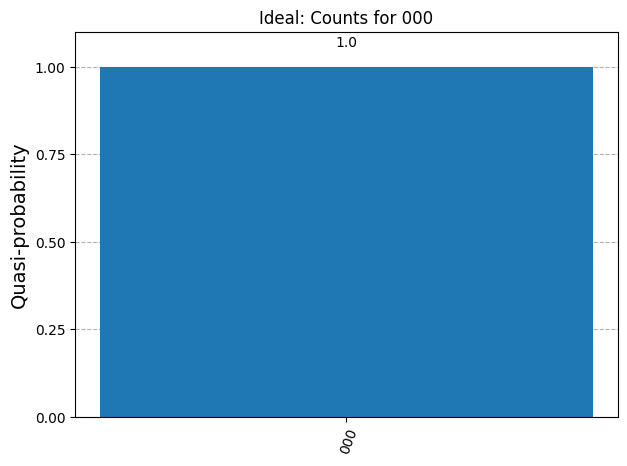


[Final HOF Circuit: Raw] (Ideal Simulation)


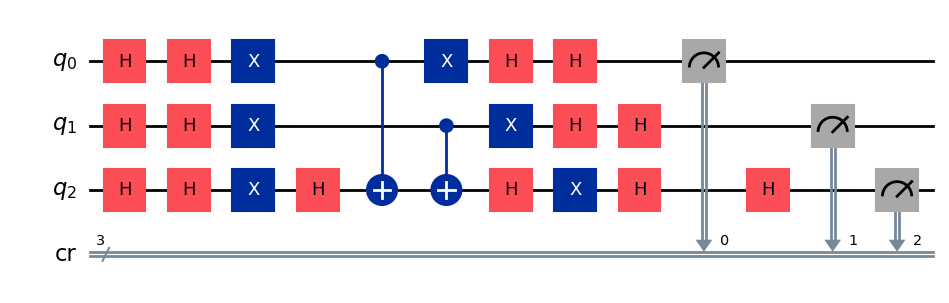


Best Individual's Fitness: 0.3600


In [26]:
print("\n[HALL OF FAME]")
sim_type_label = "Noise-Aware" if USE_NOISE_MODEL else "Ideal"
print(f"Simulation Type: {sim_type_label}")

for i, hof_ind in enumerate(hof.items):
    print(f"\nIndividual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind)

# Use deterministic seed for final evaluation
genome_hash = hash(tuple(best_ind.genome))
individual_seed = (RANDOM_SEED + genome_hash) % (2**32)

# Evaluate with current simulation mode
fitness, log_per_state = fitness_function_specialized_state_000(
    best_phenotype, 
    log_states=True,
    individual_seed=individual_seed,
    use_noise=USE_NOISE_MODEL,
)

# Explicitly write logs to disk.
evaluator.log_evaluation(log_per_state, 0, best_ind)

for log_entry in log_per_state:
    print(f"\nMarked State: {log_entry['state']}")
    print(f"Oracle:\n{log_entry['oracle']}")
    print(f"{sim_type_label} simulation - p(marked): {log_entry['p_marked']:.4f}, error: {log_entry['error']:.4f}")
    
    if USE_NOISE_MODEL:
        print(f"Transpiled Gate Count: {log_entry['gate_count']}, Transpiled Depth: {log_entry['depth']}")
    else:
        # For ideal simulation, show raw circuit metrics
        qc_temp = evaluator.execute_circuit(log_entry['code'])
        if qc_temp:
            print(f"Raw Gate Count: {qc_temp.size()}, Raw Depth: {qc_temp.depth()}")
    
    # Show distribution
    fig = plot_distribution(log_entry["counts"], title=f"{sim_type_label}: Counts for {log_entry['state']}")
    display(fig)

best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    print(f"\n[Final HOF Circuit: Raw] ({sim_type_label} Simulation)")
    display(best_circuit.draw("mpl"))
    
    # Only show transpiled circuit when using noise model
    if USE_NOISE_MODEL:
        try:
            transpiled_circuit = transpile(best_circuit, backend=backend, optimization_level=3)
            print(f"\n[Final HOF Circuit: Transpiled for Hardware]")
            print(f"Gates: {transpiled_circuit.size()}, Depth: {transpiled_circuit.depth()}")
            display(transpiled_circuit.draw("mpl", idle_wires=False))
        except Exception as e:
            print(f"[Transpile Error] {e}")
else:
    print("The best individual could not be decoded into a valid circuit.")

print(f"\nBest Individual's Fitness: {best_ind.fitness.values[0]:.4f}")

In [27]:
# Optional: Compare noise vs ideal simulation for the best individual
if USE_NOISE_MODEL:
    print("\n" + "="*60)
    print("COMPARISON: Testing best individual with ideal (noise-free) simulation")
    print("="*60)
    
    # Run with ideal simulation to see theoretical best performance
    fitness_ideal, logs_ideal = fitness_function_specialized_state_000(
        best_phenotype, 
        log_states=True,
        individual_seed=individual_seed,
        use_noise=False,  # Force ideal simulation
    )
    
    print(f"\nComparison for best individual:")
    print(f"  Noise simulation fitness: {fitness:.4f}")
    print(f"  Ideal simulation fitness: {fitness_ideal:.4f}")
    print(f"  Performance degradation due to noise: {abs(fitness - fitness_ideal):.4f}")
    
    if logs_ideal:
        print(f"\n  Noise p(marked): {log_per_state[0]['p_marked']:.4f}")
        print(f"  Ideal p(marked): {logs_ideal[0]['p_marked']:.4f}")
        print(f"  Difference: {abs(log_per_state[0]['p_marked'] - logs_ideal[0]['p_marked']):.4f}")
        
        # Show ideal distribution for comparison
        fig = plot_distribution(logs_ideal[0]["counts"], title=f"Ideal (Noise-Free): Counts for {logs_ideal[0]['state']}")
        display(fig)

## Send circuit Job to IBM


In [28]:
def run_hof_on_ibm(evaluator, hof, target_state=TARGET_STATE):
    """
    Run Hall of Fame individuals on IBM hardware.
    Note: Hardware runs cannot be seeded and will have inherent variability.
    """

    service = QiskitRuntimeService(channel="ibm_cloud", name="qgss-2025")
    backend = service.backend("ibm_brisbane")
    print(f"[QPU] Running on: {backend.name}")
    print("Note: Hardware runs are non-deterministic and cannot be seeded")
    print(f"Evolution was performed with noise model: {'ENABLED' if USE_NOISE_MODEL else 'DISABLED'}")

    sampler = Sampler(backend=backend)
    sampler.options.default_shots = NUM_SHOTS
    
    # Disable real-time streaming to avoid WebSocket errors
    sampler.options.environment.log_level = "WARNING"
    sampler.options.environment.callback = None

    for i, ind in enumerate(hof.items):
        print(f"\n[HOF Individual {i+1}] Fitness: {ind.fitness.values[0]}")

        pheno_code = evaluator.decode_individual(ind)

        qc = evaluator.execute_circuit(pheno_code)
        if qc is None:
            print(" Invalid circuit. Skipping.")
            continue
 
        pm = generate_preset_pass_manager(
            target=backend.target,
            optimization_level=3,
            seed_transpiler=RANDOM_SEED  # Transpiler can be seeded for consistency
        )
        circuit_isa = pm.run(qc)

        print("Evolved transpiled count_ops:", circuit_isa.count_ops())
        print("Evolved transpiled depth:   ", circuit_isa.depth())
        print("Total ops:       ", circuit_isa.size())
        print("Qubits / Clbits: ", circuit_isa.num_qubits, "/", circuit_isa.num_clbits)

        display(circuit_isa.draw(output="mpl", idle_wires=False))

        try:
            # Submit job and wait for results (without real-time streaming)
            print("Submitting job to quantum hardware...")
            result = sampler.run([circuit_isa]).result()
            print("Job completed successfully!")
            
            # Access the measurement data from the nested structure
            data_bin = result[0]["__value__"]["data"]
            counts = data_bin.cr.get_counts()
            counts = {k[::-1]: v for k, v in counts.items()}

            # Save plot
            fig = plot_distribution(counts, title=f"HOF #{i+1} on {backend.name}")
            display(fig)
            plot_path = os.path.join(LOG_DIR, f"hof_{i+1}_hardware_counts.png")
            fig.savefig(plot_path)
            plt.close(fig)

            # Save raw count data
            json_path = os.path.join(LOG_DIR, f"hof_{i+1}_hardware_counts.json")
            with open(json_path, "w") as f:
                json.dump(counts, f, indent=2)

            # Print hardware fidelity
            total = sum(counts.values())
            p_marked = counts.get(target_state, 0) / total if total > 0 else 0.0
            print(f"Hardware p(marked) for {target_state}: {p_marked:.4f}")
            
        except Exception as e:
            print(f"Error running on hardware: {e}")
            print("This could be a temporary connection issue. The job may still complete.")
            print("You can check job status in IBM Quantum Platform dashboard.")

qiskit_runtime_service._discover_account:WARNING:2025-08-14 08:00:15,517: Loading account with name qgss-2025. Any input 'channel', 'token' or 'url' are ignored.


[QPU] Running on: ibm_brisbane
Note: Hardware runs are non-deterministic and cannot be seeded
Evolution was performed with noise model: DISABLED

[HOF Individual 1] Fitness: 0.36
Evolved transpiled count_ops: OrderedDict([('rz', 8), ('sx', 3), ('measure', 3), ('x', 2), ('ecr', 2)])
Evolved transpiled depth:    12
Total ops:        18
Qubits / Clbits:  127 / 3


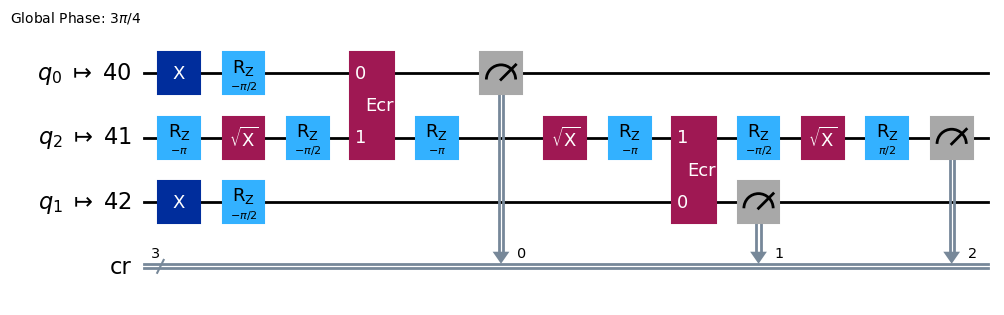

Submitting job to quantum hardware...
Job completed successfully!


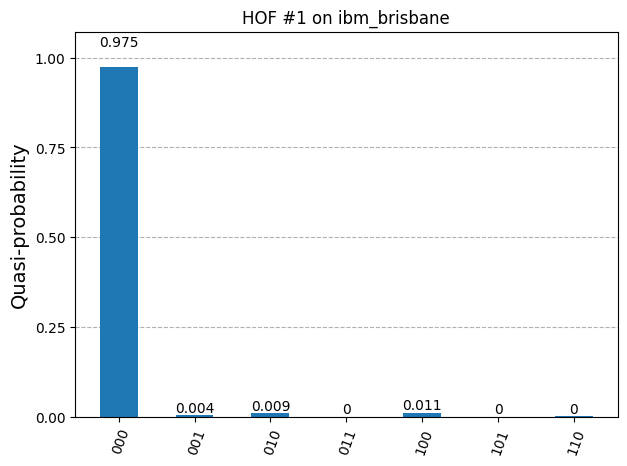

Hardware p(marked) for 000: 0.9750


In [29]:
run_hof_on_ibm(evaluator, hof, target_state=TARGET_STATE)

In [24]:
if os.path.exists(CHECKPOINT_DIR):
    checkpoints = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "*.pkl")))
    if checkpoints:
        print("Available checkpoints:")
        for cp in checkpoints:
            print(f"  - {os.path.basename(cp)}")
    else:
        print("No checkpoints found in directory.")
else:
    print(f"Checkpoint directory '{CHECKPOINT_DIR}' does not exist yet.")
    print("Checkpoints will be created when you run the evolution.")

Available checkpoints:
  - checkpoint_gen_19.pkl
  - checkpoint_gen_29.pkl
  - checkpoint_gen_39.pkl
  - checkpoint_gen_49.pkl
  - checkpoint_gen_59.pkl
  - checkpoint_gen_69.pkl
  - checkpoint_gen_79.pkl
  - checkpoint_gen_89.pkl
  - checkpoint_gen_9.pkl
  - checkpoint_gen_99.pkl
  - checkpoint_latest.pkl


In [25]:
# Utility: Clear all checkpoints (run this for a fresh start)
# if os.path.exists(CHECKPOINT_DIR):
#     shutil.rmtree(CHECKPOINT_DIR)
#     os.makedirs(CHECKPOINT_DIR)
#     print("All checkpoints cleared!")